# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

### `Notes:`

#### 1. We have downloaded keras implementation for efficientnets from below location and have provided as part of zip file for the project:

https://github.com/titu1994/keras-efficientnets



#### 2. We have downloaded keras implementation for AdaBound optimizer from this location and have provided as part of zip file for the project:

https://github.com/titu1994/keras-adabound

#### 3. We have uploaded all models on google drive to save size of project zip file and provided links to respective models at appropriate places. Please download models from the links provided.

#### 4. For testing/evaluation, please use model 30 (EfficientNet_B0 + GRU).

#### Model saved - Size: 52.8 MB -

#### `(https://drive.google.com/file/d/1yr2SGfnf6ITgVcx4IE6x9CBOWdXAl4-S/view?usp=sharing)`

#### If needed, further testing/evaluation can be done using next best model also which is model 28 (MobileNet + GRU).

#### Model saved – Size: 42.1 MB - 

#### `(https://drive.google.com/file/d/1XuaWXSswKAvO-7U2h5IYTZxxYEUeRBf7/view?usp=sharing)`


##### Import all libraries

In [2]:
import numpy as np
import os
#from scipy.misc import imread, imresize ## Commented out as not able to find these
import datetime
import os
import random as rn
import tensorflow as tf
from keras import backend as K

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

# Added based on the need while working on the project
import pandas as pd
from skimage import io
from skimage.transform import resize
import glob
import gc
import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import Dropout, ZeroPadding3D, GlobalAveragePooling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D 
from keras.layers.recurrent import LSTM
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD
from keras.utils import plot_model
from keras.regularizers import l2
from keras.backend.tensorflow_backend import clear_session, get_session
from keras_applications.mobilenet import MobileNet
from keras_applications.mobilenet_v2 import MobileNetV2
from keras_efficientnets.efficientnet import EfficientNetB0, EfficientNetB2

from adabound import AdaBound

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
rn.seed(30)
tf.set_random_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 10 #experiment with the batch size

##### Lets check shape of images in training data set as well as in validation data set

In [4]:
# Function to get unique shape of the images
def chk_image_shape(df, path, image_set):
    for data in df['foldername']:
        dirs = path + data
        images = os.listdir(dirs)
    
        for rec in images:
            image_name = dirs + '/' + rec
            image = io.imread(image_name)
            image_set.add(image.shape)
    
    return image_set

##### Training data

In [5]:
train_df = pd.read_csv('Project_data/train.csv', sep = ';', skipinitialspace = True, header = None)
train_df.columns = ['foldername', 'type', 'value']

train_df

,foldername,type,value
0,WIN_20180925_17_08_43_Pro_Left_Swipe_new,Left_Swipe_new,0
1,WIN_20180925_17_18_28_Pro_Left_Swipe_new,Left_Swipe_new,0
2,WIN_20180925_17_18_56_Pro_Left_Swipe_new,Left_Swipe_new,0
3,WIN_20180925_17_19_51_Pro_Left_Swipe_new,Left_Swipe_new,0
4,WIN_20180925_17_20_14_Pro_Left_Swipe_new,Left_Swipe_new,0
5,WIN_20180925_17_21_28_Pro_Left_Swipe_new,Left_Swipe_new,0
6,WIN_20180925_17_22_55_Pro_Left_Swipe_new,Left_Swipe_new,0
7,WIN_20180925_17_24_49_Pro_Left_Swipe_new,Left_Swipe_new,0
8,WIN_20180925_17_26_25_Pro_Left_Swipe_new,Left_Swipe_new,0
9,WIN_20180925_17_26_51_Pro_Left_Swipe_new,Left_Swipe_new,0


##### Validation data

In [6]:
val_df = pd.read_csv('Project_data/val.csv', sep = ';', skipinitialspace = True, header = None)
val_df.columns = ['foldername', 'type', 'value']

val_df

,foldername,type,value
0,WIN_20180925_17_17_04_Pro_Left_Swipe_new,Left_Swipe_new,0
1,WIN_20180925_17_43_01_Pro_Left_Swipe_new,Left_Swipe_new,0
2,WIN_20180925_18_01_40_Pro_Left_Swipe_new,Left_Swipe_new,0
3,WIN_20180925_18_03_21_Pro_Left_Swipe_new,Left_Swipe_new,0
4,WIN_20180926_16_46_22_Pro_Left_Swipe_new,Left_Swipe_new,0
5,WIN_20180926_16_47_09_Pro_Left_Swipe_new,Left_Swipe_new,0
6,WIN_20180926_17_05_38_Pro_Left_Swipe_new,Left_Swipe_new,0
7,WIN_20180926_17_08_09_Pro_Left_Swipe_new,Left_Swipe_new,0
8,WIN_20180926_17_09_33_Pro_Left_Swipe_new,Left_Swipe_new,0
9,WIN_20180926_17_15_35_Pro_Left_Swipe_new,Left_Swipe_new,0


##### Image shape check in training data

In [7]:
# Check size of all the images in training data and create a set just to keep unique values.
image_set_train = set()
image_set_train = chk_image_shape(train_df, 'Project_data/train/', image_set_train)

image_set_train

{(120, 160, 3), (360, 360, 3)}

##### Image shape check in validation data

In [8]:
# Check size of all the images in validation data and create a set just to keep unique values.
image_set_val = set()
image_set_val = chk_image_shape(val_df, 'Project_data/val/', image_set_val)

image_set_val

{(120, 160, 3), (360, 360, 3)}

Both Training and Validation dataset has both shape of images `[(360, 360, 3), (120, 160, 3)]`.

To keep it consistent, we will have to reshape images. Lets reshape all images to `(120, 120, 3)`.

For images with dimension `(360, 360, 3)`, resize image to dimension `(120, 120, 3)`.

For images with dimension `(120, 160, 3)`, crop image to dimension `(120, 120, 3)`.

In [9]:
# Function to resize / crop the image to (120, 120, 3) and display the image
def image_resize_crop(image_type, sample_image_name):
    print(image_type)
    print('**************************************************************')
    
    sample_image = io.imread(sample_image_name)
    print('\nOriginal Shape =', sample_image.shape)

    if sample_image.shape[0] == 120:
        # Image Crop
        new_image = sample_image[0:120, 0:120]
        print('\nNew Shape =', new_image.shape)
    
    elif sample_image.shape[0] == 360:
        # Image Resize
        new_image = resize(sample_image, (120, 120))
        print('\nNew Shape =', new_image.shape)

    f, axes = plt.subplots(1, 5)
    f.set_figwidth(20)

    # Original Image
    axes[0].imshow(sample_image)
    # New Cropped/Resize Image
    axes[1].imshow(new_image)
    # RGB channels of the new image
    axes[2].imshow(new_image[:, : , 0])
    axes[3].imshow(new_image[:, : , 1])
    axes[4].imshow(new_image[:, : , 2])
    f.suptitle('Original to Transformed Image and its different channels')
    plt.show()

Thumbs down - Cropping from (120, 160, 3) to (120, 120, 3)
**************************************************************

Original Shape = (120, 160, 3)

New Shape = (120, 120, 3)


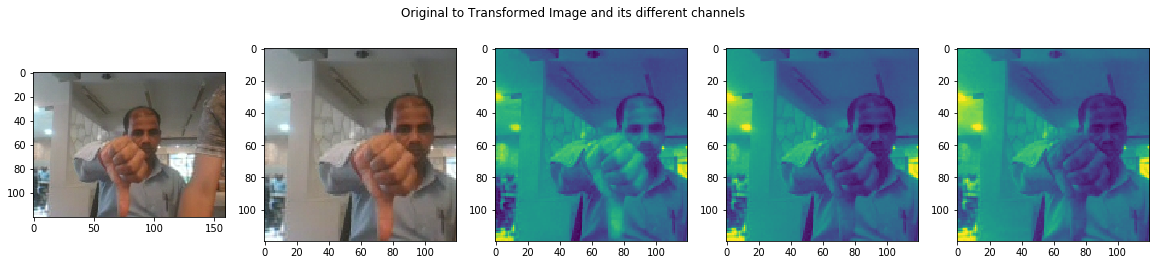

In [10]:
# Crop image (120, 160, 3) to (120, 120, 3)
image_type = 'Thumbs down - Cropping from (120, 160, 3) to (120, 120, 3)'
sample_image_name = 'Project_data/train/WIN_20180925_17_34_05_Pro_Thumbs_Down_new/WIN_20180925_17_34_05_Pro_00089.png'

image_resize_crop(image_type, sample_image_name)

Right Swipe - Cropping from (120, 160, 3) to (120, 120, 3)
**************************************************************

Original Shape = (120, 160, 3)

New Shape = (120, 120, 3)


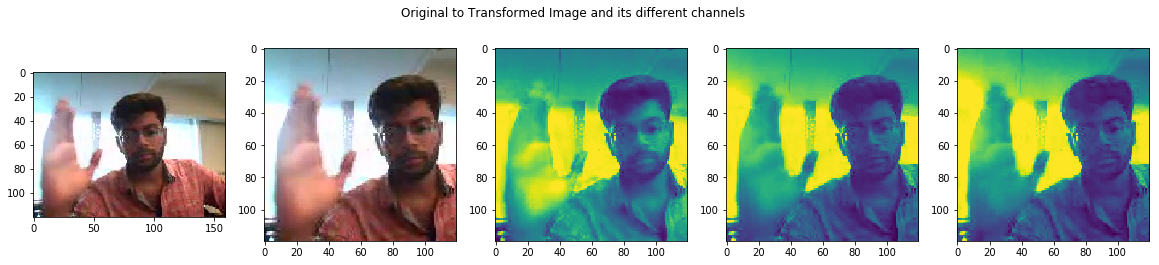

In [11]:
# Crop image (120, 160, 3) to (120, 120, 3)
image_type = 'Right Swipe - Cropping from (120, 160, 3) to (120, 120, 3)'
sample_image_name = 'Project_data/train/WIN_20180925_17_34_40_Pro_Right_Swipe_new/WIN_20180925_17_34_40_Pro_00043.png'

image_resize_crop(image_type, sample_image_name)

Left Swipe - Resize from (360, 360, 3) to (120, 120, 3)
**************************************************************

Original Shape = (360, 360, 3)

New Shape = (120, 120, 3)


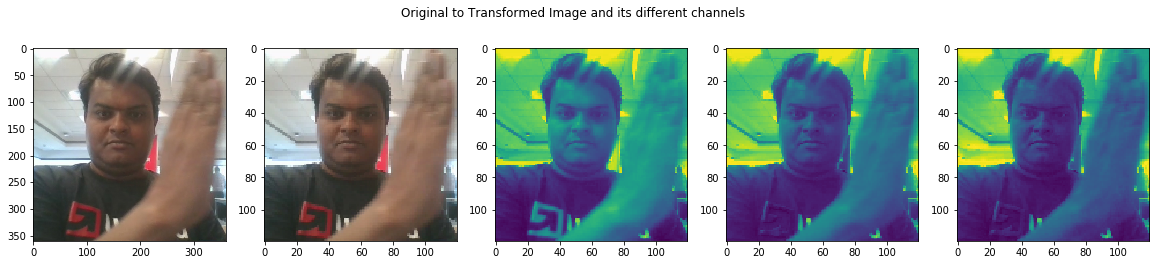

In [12]:
# Resize image (360, 360, 3) to (120, 120, 3)
image_type = 'Left Swipe - Resize from (360, 360, 3) to (120, 120, 3)'
sample_image_name = 'Project_data/train/WIN_20180907_15_52_28_Pro_Left Swipe_new_Left Swipe_new/WIN_20180907_15_52_28_Pro_00036.png'

image_resize_crop(image_type, sample_image_name)

Thumbs up - Resize from (360, 360, 3) to (120, 120, 3)
**************************************************************

Original Shape = (360, 360, 3)

New Shape = (120, 120, 3)


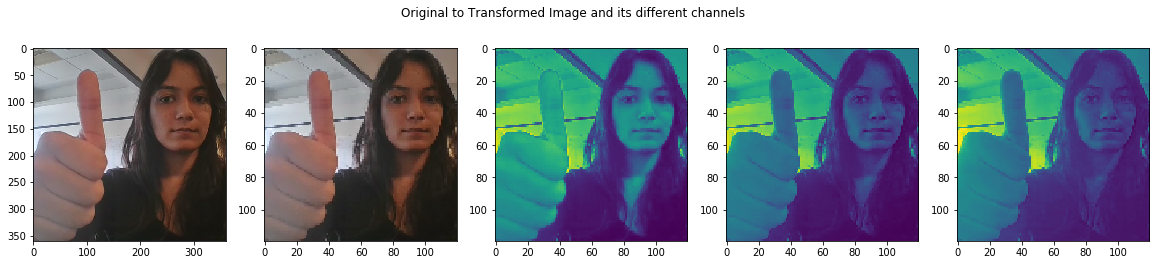

In [13]:
# Resize image (360, 360, 3) to (120, 120, 3)
image_type = 'Thumbs up - Resize from (360, 360, 3) to (120, 120, 3)'
sample_image_name = 'Project_data/train/WIN_20180907_15_53_12_Pro_Thumbs Up_new/WIN_20180907_15_53_12_Pro_00069.png'

image_resize_crop(image_type, sample_image_name)

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = [k for k in range(0, 30)]
    x = 30
    y = 120
    z = 120
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    # We will crop the image to (120, 120, 3), if the shape is (120, 160, 3)
                    # and we will resize to (120, 120, 3), if the shape is (360, 360, 3)
                    
                    if image.shape[0] == 120:
                        # Image Crop
                        image = image[0:120, 0:120]
                    elif image.shape[0] == 360:
                        # Image Resize
                        image = resize(image, (120, 120))
                    
                    batch_data[folder,idx,:,:,0] = image[:, :, 0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:, :, 1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:, :, 2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches
        
        remaining_data_points = len(t) - (num_batches * batch_size) # calculate the number of remaining data points
        if remaining_data_points > 0:
            batch_data = np.zeros((remaining_data_points,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_data_points,5)) # batch_labels is the one hot representation of the output
            for folder in range(remaining_data_points): # iterate over the remaining_data_points
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    # We will crop the image to (120, 120, 3), if the shape is (120, 160, 3)
                    # and we will resize to (120, 120, 3), if the shape is (360, 360, 3)
                    
                    if image.shape[0] == 120:
                        # Image Crop
                        image = image[0:120, 0:120]
                    elif image.shape[0] == 360:
                        # Image Resize
                        image = resize(image, (120, 120))
                    
                    batch_data[folder,idx,:,:,0] = image[:, :, 0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:, :, 1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:, :, 2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

#### In addition to above, have tried transfer learning models as well. So there are 3 types: 
`Conv2D + RNN` <br></br>
`Conv3D` <br></br>
`Transfer Learning + RNN`

In [17]:
###############
## Model #1 ##
###########################################################################
## Conv2D + RNN (LSTM) - Time Distributed Model - 4 Convolutional Layers 
## filter size 3 and stride size 2
#########################################################################
def conv2d_lstm_4cl(input_shape, nb_classes, filter_size = (3,3), dropout = 0.25):

    model = Sequential()

    model.add(TimeDistributed(Conv2D(16, filter_size, strides=(2, 2), activation='relu', padding='same'), input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(32, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(64, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(128, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Flatten()))

    # Add LSTM layer
    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(dropout))

    model.add(Dense(nb_classes, activation='softmax'))

    return model

###############
## Model #2 ##
#########################################################################################
## Conv2D + RNN (LSTM) - Time Distributed Model - 4 Convolutional Layers with Dropouts
## filter size 3 and stride size 2
########################################################################################
def conv2d_lstm_4cl_dropouts(input_shape, nb_classes, filter_size = (3,3), dropout = 0.25):

    model = Sequential()

    model.add(TimeDistributed(Conv2D(16, filter_size, strides=(2, 2), activation='relu', padding='same'), input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(Dropout(dropout)) # adding the dropout layer at each convolution layer

    model.add(TimeDistributed(Conv2D(32, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(Dropout(dropout)) # adding the dropout layer at each convolution layer

    model.add(TimeDistributed(Conv2D(64, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(Dropout(dropout)) # adding the dropout layer at each convolution layer

    model.add(TimeDistributed(Conv2D(128, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(Dropout(dropout)) # adding the dropout layer at each convolution layer

    model.add(TimeDistributed(Flatten()))

    # Add LSTM layer
    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(dropout))

    model.add(Dense(nb_classes, activation='softmax'))

    return model

###############
## Model #3 ##
###########################################################################
## Conv2D + RNN (LSTM) - Time Distributed Model - 4 Convolutional Layers 
## filter size 1 and defaul stride size
##########################################################################
def conv2d_lstm_4cl_filter(input_shape, nb_classes, filter_size = (1,1), dropout = 0.25):

    model = Sequential()

    model.add(TimeDistributed(Conv2D(16, filter_size, activation='relu', padding='same'), input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(32, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(64, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(128, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Flatten()))

    # Add LSTM layer
    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(dropout))

    model.add(Dense(nb_classes, activation='softmax'))

    return model

###############
## Model #4 ##
###########################################################################
## Conv2D + RNN (LSTM) - Time Distributed Model - 4 Convolutional Layers 
## filter size 1 and defaul stride size
## adding another layer with l2 regularizer before softmaxlayer
##########################################################################
def conv2d_lstm_4cl_filter_l2_regularizer(input_shape, nb_classes, filter_size = (1,1), dropout = 0.25):

    model = Sequential()

    model.add(TimeDistributed(Conv2D(16, filter_size, activation='relu', padding='same'), input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(32, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(64, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(128, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Flatten()))

    # Add LSTM layer
    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(dropout))

    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))   
    
    model.add(Dense(nb_classes, activation='softmax'))

    return model

###############
## Model #5 ##
###########################################################################
## Conv2D + RNN (LSTM) - Time Distributed Model - 5 Convolutional Layers
## filter size 1 and defaul stride size
##########################################################################
def conv2d_lstm_5cl_filter(input_shape, nb_classes, filter_size = (1,1), dropout = 0.25):

    model = Sequential()

    model.add(TimeDistributed(Conv2D(16, filter_size, activation='relu', padding='same'), input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(32, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(64, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(128, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    # Adding additional convolutional layer
    model.add(TimeDistributed(Conv2D(256, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Flatten()))

    # Add LSTM layer
    model.add(LSTM(256, return_sequences=False))
    model.add(Dropout(dropout))
    
    model.add(Dense(nb_classes, activation='softmax'))

    return model

###############
## Model #6 ##
###########################################################################
## Conv2D + RNN (LSTM) - Time Distributed Model - 5 Convolutional Layers
## filter size 1 and defaul stride size
## with l2 regularizer before softmaxlayer
##########################################################################
def conv2d_lstm_5cl_filter_l2_regularizer(input_shape, nb_classes, filter_size = (1,1), dropout = 0.25):

    model = Sequential()

    model.add(TimeDistributed(Conv2D(16, filter_size, activation='relu', padding='same'), input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(32, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(64, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(128, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    # Adding additional convolutional layer
    model.add(TimeDistributed(Conv2D(256, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Flatten()))

    # Add LSTM layer
    model.add(LSTM(256, return_sequences=False))
    model.add(Dropout(dropout))

    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout)) 
    
    model.add(Dense(nb_classes, activation='softmax'))

    return model

###############
## Model #7 ##
###########################################################################
## Conv2D + RNN (LSTM) - Time Distributed Model - 6 Convolutional Layers
## filter size 1 and defaul stride size
##########################################################################
def conv2d_lstm_6cl_filter(input_shape, nb_classes, filter_size = (1,1), dropout = 0.25):

    model = Sequential()

    model.add(TimeDistributed(Conv2D(16, filter_size, activation='relu', padding='same'), input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(32, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(64, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(128, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(256, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    # Adding additional convolutional layer
    model.add(TimeDistributed(Conv2D(256, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    model.add(TimeDistributed(Flatten()))

    # Add LSTM layer
    model.add(LSTM(256, return_sequences=False))
    model.add(Dropout(dropout))
    
    model.add(Dense(nb_classes, activation='softmax'))

    return model

###############
## Model #8 ##
##########################################################################
## Conv2D + RNN (GRU) - Time Distributed Model - 4 Convolutional Layers
## filter size 3 and stride size 2
#########################################################################
def conv2d_gru_4cl(input_shape, nb_classes, filter_size = (3,3), dropout = 0.25):

    model = Sequential()

    model.add(TimeDistributed(Conv2D(16, filter_size, strides=(2, 2), activation='relu', padding='same'), input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(32, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(64, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(128, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Flatten()))

    # Add GRU layer
    model.add(GRU(128, return_sequences=False))
    model.add(Dropout(dropout))

    model.add(Dense(nb_classes, activation='softmax'))

    return model

###############
## Model #9 ##
#########################################################################################
## Conv2D + RNN (GRU) - Time Distributed Model - 4 Convolutional Layers with Dropouts
## filter size 3 and stride size 2
########################################################################################
def conv2d_gru_4cl_dropouts(input_shape, nb_classes, filter_size = (3,3), dropout = 0.25):

    model = Sequential()

    model.add(TimeDistributed(Conv2D(16, filter_size, strides=(2, 2), activation='relu', padding='same'), input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(Dropout(dropout)) # adding the dropout layer at each convolution layer

    model.add(TimeDistributed(Conv2D(32, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(Dropout(dropout)) # adding the dropout layer at each convolution layer

    model.add(TimeDistributed(Conv2D(64, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(Dropout(dropout)) # adding the dropout layer at each convolution layer

    model.add(TimeDistributed(Conv2D(128, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(Dropout(dropout)) # adding the dropout layer at each convolution layer

    model.add(TimeDistributed(Flatten()))

    # Add GRU layer
    model.add(GRU(128, return_sequences=False))
    model.add(Dropout(dropout))

    model.add(Dense(nb_classes, activation='softmax'))

    return model
    
################
## Model #10 ##
##########################################################################
## Conv2D + RNN (GRU) - Time Distributed Model - 4 Convolutional Layers
## filter size 1 and defaul stride size
#########################################################################
def conv2d_gru_4cl_filter(input_shape, nb_classes, filter_size = (1,1), dropout = 0.25):

    model = Sequential()

    model.add(TimeDistributed(Conv2D(16, filter_size, activation='relu', padding='same'), input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(32, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(64, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(128, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Flatten()))

    # Add GRU layer
    model.add(GRU(128, return_sequences=False))
    model.add(Dropout(dropout))

    model.add(Dense(nb_classes, activation='softmax'))

    return model

################
## Model #11 ##
##########################################################################
## Conv2D + RNN (GRU) - Time Distributed Model - 4 Convolutional Layers
## filter size 1 and defaul stride size
## adding another layer with l2 regularizer before softmaxlayer
#########################################################################
def conv2d_gru_4cl_filter_l2_regularizer(input_shape, nb_classes, filter_size = (1,1), dropout = 0.25):

    model = Sequential()

    model.add(TimeDistributed(Conv2D(16, filter_size, activation='relu', padding='same'), input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(32, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(64, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(128, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Flatten()))

    # Add GRU layer
    model.add(GRU(128, return_sequences=False))
    model.add(Dropout(dropout))

    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout)) 
    
    model.add(Dense(nb_classes, activation='softmax'))

    return model

################
## Model #12 ##
##########################################################################
## Conv2D + RNN (GRU) - Time Distributed Model - 5 Convolutional Layers
## filter size 1 and defaul stride size
#########################################################################
def conv2d_gru_5cl_filter(input_shape, nb_classes, filter_size = (1,1), dropout = 0.25):

    model = Sequential()

    model.add(TimeDistributed(Conv2D(16, filter_size, activation='relu', padding='same'), input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(32, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(64, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(128, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    # Add additional convolutional layers
    model.add(TimeDistributed(Conv2D(256, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Flatten()))

    # Add GRU layer
    model.add(GRU(256, return_sequences=False))
    model.add(Dropout(dropout))
    
    model.add(Dense(nb_classes, activation='softmax'))

    return model

################
## Model #13 ##
##########################################################################
## Conv2D + RNN (GRU) - Time Distributed Model - 5 Convolutional Layers
## filter size 1 and defaul stride size
## with l2 regularizer before softmaxlayer
#########################################################################
def conv2d_gru_5cl_filter_l2_regularizer(input_shape, nb_classes, filter_size = (1,1), dropout = 0.25):

    model = Sequential()

    model.add(TimeDistributed(Conv2D(16, filter_size, activation='relu', padding='same'), input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(32, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(64, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(128, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    # Add additional convolutional layers
    model.add(TimeDistributed(Conv2D(256, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Flatten()))

    # Add GRU layer
    model.add(GRU(256, return_sequences=False))
    model.add(Dropout(dropout))

    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    
    model.add(Dense(nb_classes, activation='softmax'))

    return model

################
## Model #14 ##
##########################################################################
## Conv2D + RNN (GRU) - Time Distributed Model - 6 Convolutional Layers
## filter size 1 and defaul stride size
#########################################################################
def conv2d_gru_6cl_filter(input_shape, nb_classes, filter_size = (1,1), dropout = 0.25):

    model = Sequential()

    model.add(TimeDistributed(Conv2D(16, filter_size, activation='relu', padding='same'), input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(32, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(64, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(128, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(256, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    # Add additional convolutional layers
    model.add(TimeDistributed(Conv2D(256, filter_size, padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    model.add(TimeDistributed(Flatten()))

    # Add GRU layer
    model.add(GRU(256, return_sequences=False))
    model.add(Dropout(dropout))
    
    model.add(Dense(nb_classes, activation='softmax'))

    return model

################
## Model #15 ##
###########################################
## Conv3D Model - 4 Colvolutional Layers
##########################################
def conv3d_4cl(input_shape, nb_classes, filter_size = (3,3,3), dropout = 0.25):

    model = Sequential()

    model.add(Conv3D(16, filter_size, padding='same',input_shape = input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(32, filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(128, filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(128,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(nb_classes,activation='softmax'))

    return model

################
## Model #16 ##
#########################################################
## Conv3D Model - 4 Colvolutional Layers with Dropouts
########################################################
def conv3d_4cl_dropouts(input_shape, nb_classes, filter_size = (3,3,3), dropout = 0.25):

    model = Sequential()

    model.add(Conv3D(16, filter_size, padding='same', input_shape = input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(dropout)) # adding the dropout layer at each convolution layer

    model.add(Conv3D(32, filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(dropout)) # adding the dropout layer at each convolution layer

    model.add(Conv3D(64, filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(dropout)) # adding the dropout layer at each convolution layer

    model.add(Conv3D(128, filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(dropout)) # adding the dropout layer at each convolution layer

    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(128,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))


    model.add(Dense(nb_classes, activation='softmax'))

    return model

################
## Model #17 ##
#################################################################
## Conv3D Model - 4 Colvolutional Layers with l2 regularization
################################################################
def conv3d_4cl_l2_regularizer(input_shape, nb_classes, filtersize = (3,3,3), dropout = 0.25):

    model = Sequential()

    model.add(Conv3D(16, filtersize, padding='same', input_shape = input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(32, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(128, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(nb_classes, activation='softmax'))

    return model

################
## Model #18 ##
###########################################
## Conv3D Model - 4 Colvolutional Layers
## filter size 1
##########################################
def conv3d_4cl_filter(input_shape, nb_classes, filter_size = (1,1,1), dropout = 0.25):

    model = Sequential()

    model.add(Conv3D(16, filter_size, padding='same',input_shape = input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(32, filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(128, filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(128,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(nb_classes,activation='softmax'))

    return model

################
## Model #19 ##
##################################################################
## Conv3D Model - 4 Colvolutional Layers with l2 regularization
## fitler size 1
#################################################################
def conv3d_4cl_filter_l2_regularizer(input_shape, nb_classes, filtersize = (1,1,1), dropout = 0.25):

    model = Sequential()

    model.add(Conv3D(16, filtersize, padding='same', input_shape = input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(32, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(128, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(nb_classes, activation='softmax'))

    return model

################
## Model #20 ##
############################################
## Conv3D Model - 5 Colvolutional Layers
###########################################
def conv3d_5cl(input_shape, nb_classes, filter_size = (3,3,3), dropout = 0.25):

    model = Sequential()

    model.add(Conv3D(16, filter_size, input_shape = input_shape, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(32, filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(128, filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Adding additional convolutional layer
    model.add(Conv3D(256, filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(256,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(nb_classes,activation='softmax'))

    return model

################
## Model #21 ##
#########################################################
## Conv3D Model - 5 Colvolutional Layers with Dropouts
########################################################
def conv3d_5cl_dropouts(input_shape, nb_classes, filter_size = (3,3,3), dropout = 0.25):

    model = Sequential()

    model.add(Conv3D(16, filter_size, input_shape = input_shape, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(dropout)) # adding the dropout layer at each convolution layer
    
    model.add(Conv3D(32, filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(dropout)) # adding the dropout layer at each convolution layer
    
    model.add(Conv3D(64, filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(dropout)) # adding the dropout layer at each convolution layer
    
    model.add(Conv3D(128, filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(dropout)) # adding the dropout layer at each convolution layer

    # Adding additional convolutional layer
    model.add(Conv3D(256, filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout)) # adding the dropout layer at each convolution layer
    
    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(256,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(nb_classes,activation='softmax'))

    return model

################
## Model #22 ##
#################################################################
## Conv3D Model - 5 Colvolutional Layers with l2 regularization
################################################################
def conv3d_5cl_l2_regularizer(input_shape, nb_classes, filter_size = (3,3,3), dropout = 0.25):

    model = Sequential()

    model.add(Conv3D(16, filter_size, padding='same', input_shape = input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(32, filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(128, filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Adding additional convolutional layer
    model.add(Conv3D(256, filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(nb_classes, activation='softmax'))

    return model

################
## Model #23 ##
############################################
## Conv3D Model - 5 Colvolutional Layers
## filter size 1
###########################################
def conv3d_5cl_filter(input_shape, nb_classes, filter_size = (1,1,1), dropout = 0.25):

    model = Sequential()

    model.add(Conv3D(16, filter_size, input_shape = input_shape, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(32, filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(128, filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Adding additional convolutional layer
    model.add(Conv3D(256, filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(256,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(nb_classes,activation='softmax'))

    return model

################
## Model #24 ##
#################################################################
## Conv3D Model - 5 Colvolutional Layers with l2 regularization
## filter size 1
################################################################
def conv3d_5cl_filter_l2_regularizer(input_shape, nb_classes, filter_size = (1,1,1), dropout = 0.25):

    model = Sequential()

    model.add(Conv3D(16, filter_size, padding='same', input_shape = input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(32, filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(128, filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Adding additional convolutional layer
    model.add(Conv3D(256, filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(nb_classes, activation='softmax'))

    return model

################
## Model #25 ##
############################################
## Conv3D Model - 6 Colvolutional Layers
## filter size 1
###########################################
def conv3d_6cl_filter(input_shape, nb_classes, filter_size = (1,1,1), dropout = 0.25):

    model = Sequential()

    model.add(Conv3D(16, filter_size, input_shape = input_shape, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(32, filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(128, filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(256, filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    # Adding additional convolutional layer
    model.add(Conv3D(256, filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(256,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(nb_classes,activation='softmax'))

    return model

################
## Model #26 ##
#################################################################
## Conv3D Model - 6 Colvolutional Layers with l2 regularization
## filter size 1
################################################################
def conv3d_6cl_filter_l2_regularizer(input_shape, nb_classes, filter_size = (1,1,1), dropout = 0.25):

    model = Sequential()

    model.add(Conv3D(16, filter_size, padding='same', input_shape = input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(32, filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(128, filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(256, filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    # Adding additional convolutional layer
    model.add(Conv3D(256, filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(nb_classes, activation='softmax'))

    return model

################
## Model #27 ##
############################################
## Conv3D Model - 7 Colvolutional Layers
## filter size 1
###########################################
def conv3d_7cl_filter(input_shape, nb_classes, filter_size = (1,1,1), dropout = 0.25):

    model = Sequential()

    model.add(Conv3D(16, filter_size, input_shape = input_shape, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(32, filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(128, filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(256, filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv3D(256, filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    # Adding additional convolutional layer
    model.add(Conv3D(256, filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(256,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(nb_classes,activation='softmax'))

    return model

################
## Model #28 ##
################################################################################
## Transfer Learning Model using MobileNet with GRU with trainable layers
###############################################################################
def mobilenet_transfer_learning_gru(input_shape, nb_classes, dropout = 0.25):

    # Create base pre-trained model
    mobilenet_transfer = MobileNet(weights='imagenet', include_top=False)

    model = Sequential()
    model.add(TimeDistributed(mobilenet_transfer, input_shape = input_shape))

    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))

    # GRU
    model.add(GRU(128, activation='relu', dropout=dropout))

    # Output layer
    model.add(Dense(nb_classes, activation='softmax'))

    return model

################
## Model #29 ##
#################################################################################
## Transfer Learning Model using MobileNetV2 with GRU with trainable layers
################################################################################
def mobilenet_v2_transfer_learning_gru(input_shape, nb_classes, dropout=0.25):

    # Create base pre-trained model
    mobilenet_v2_transfer = MobileNetV2(weights='imagenet', include_top=False)

    model = Sequential()

    model.add(TimeDistributed(mobilenet_v2_transfer, input_shape = input_shape))

    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))

    # GRU
    model.add(GRU(128, activation='relu', dropout=dropout))

    # Output layer
    model.add(Dense(nb_classes, activation='softmax'))

    return model

################
## Model #30 ##
####################################################################################
## Transfer Learning Model using EfficientNetB0 with GRU with trainable layers
## https://github.com/titu1994/keras-efficientnets
## pip install keras-efficientnets
###################################################################################
def efficientnet_b0_transfer_learning_gru(input_shape, nb_classes, dropout=0.25):

    # Create base pre-trained model
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)

    # Add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Create fine tuned base model
    base_model = Model(inputs=base_model.input, outputs=x)

    # This is the model we will train
    model = Sequential()

    # Add the base model on top of the final model
    model.add(TimeDistributed(base_model, input_shape=base_model.input_shape))
    model.add(TimeDistributed(Flatten(input_shape=base_model.input_shape[1:])))

    # GRU
    model.add(GRU(128, activation='relu', dropout=dropout))

    # output layer
    model.add(Dense(nb_classes, activation = 'softmax'))

    return model

##### Function to train various models

In [7]:
# Function to train the model. Have combined various steps into one function so can be used repeatedly
# https://github.com/titu1994/keras-adabound - Adabound
def train_model(model, batch_size, num_epochs, train_generator, val_generator, model_full_name, optimizer_used = None):

    # Initialize optimizer
    if optimizer_used == None:
        optimizer_used = Adam() ## If None is passed then use Adam as optimizer    

    # Compile the model and print summary of the model. You will see the total number of parameters in the model
    model.compile(optimizer = optimizer_used, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
    print (model.summary())

    curr_dt_time = datetime.datetime.now()
    
    # Commented this line and having folder name more readable in next line
#     model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

    model_name = 'model_' + model_full_name + '/'    

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    # Commented this line as model name being saved is not readable, saving best model to simplify names in next line
#     filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    filepath = model_name + model_full_name +'_best_model.h5'

    # generate the model checkpoint.
    checkpoint = ModelCheckpoint(filepath, 
                                 monitor = 'val_loss', 
                                 verbose = 1, 
                                 save_best_only = True, 
                                 save_weights_only = False, 
                                 mode = 'auto', 
                                 period = 1)

    LR = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 2, cooldown = 1, verbose = 1)
    ES = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    callbacks_list = [checkpoint, ES, LR]

    # Initialize train parameters - steps_per_epoch and validation_steps are used by 
    # fit_generator to decide the number of next() calls it need to make.
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1


    # Now Fit the model - This will start training the model and with the help of the checkpoints, 
    # you will be able to save the model at the end of each epoch.
    model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                callbacks=callbacks_list, validation_data=val_generator, 
                validation_steps=validation_steps, class_weight=None, workers = 1, initial_epoch=0)

    return model_history

##### Function to plot history of various models

In [8]:
# Function to plot Loss & Accuracy curves for the train and validation data from model history
def plot_model_history(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

##### Function to clean up previous keras sessions

In [9]:
## Function to cleanup keras session to start afresh with new model 
## (Found from https://forums.fast.ai/t/how-could-i-release-gpu-memory-of-keras/2023/17)
def cleanup_keras_session():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del base_model, model
    except:
        pass
    
    K.clear_session()

    gc.collect()
    print("Keras Session Cleaned up...")

##### Setup parameters to be passed to train models

And also let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [16]:
train_path = 'Project_data/train'
val_path = 'Project_data/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

input_shape = (30, 120, 120, 3)
nb_classes = 5

## Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## `Batch Size`

#### We tried with different batch sizes of - 10/20/30/32/64

For some models, batch size of 64 was working fine but with many other models, we were facing GPU memory issue.

For many models, batch size of 20/30/32 was working fine but with some other models, we were facing GPU memory issue (mainly in case of transfer learning models).

For all models, batch size of 10 was working absolutely fine.

Infact, training was happening slightly faster with batch size as 10 in comparison to other batch sizes.

And we were getting good accuracy with batch size as 10 in comparison to other batch sizes.

#### So in order to be consistent across models + achieve slightly faster training + achieve good accuracy, we decided to keep batch size as 10.

## `Number of Epochs`

#### We tried with different number of epochs - 10/20/30/40

Beyond 20 epochs, not much learning was happening and we were reaching plateau again and again. Not much gain was observed in accuracy also.

#### So we decided to keep number of epochs as 20.

- For some models, even 10 epochs were enough but we still have kept 20 epochs to keep it consistent and show variations in other models.

- For some models with l2 regularizer, we have trained with 30 epochs just to show that there was not much benefit with more number of epochs.

- For transfer learning models, we have kept number of epochs as 10 as model was already hitting categorical accuracy (> 0.98-0.99).

## `Number of Models`

#### We have shown below total of 32 models.

- First 3 models, `compare Adam, AdaBound and SGD optimizer`. We researched about optimizers and found keras implementation of AdaBound and tried to compare its performance.
- Next 6 models on `LSTM`
- Next 7 models on `GRU`
- Next 13 models on `Conv3D`
- Next 3 models on `Transfer Learning`

## `Comparison of Models`


We have compared models within their families. Like comparison of (Conv2D + LSTM) model is done with another (Conv2D + LSTM) model only, (Conv2D + GRU) model with another (Conv2D + GRU) model, Conv3D model with another Conv3D model and Transfer Learning model with another Transfer Learning model.

However, at the end, we have suggested our best model among all these. We have also noticed that:

- `GRU models performed better than LSTM models.`

- `Conv3D models performed better than GRU models.`

- `Transfer Learning models outperformed all others.`

## `LSTM Based Models`

### Model 1 (A) - conv2d_lstm_4cl with Adam as optimizer

`Conv2D - 4 layers (Neurons - 16/32/64/128) + LSTM + Adam (optimizer) + Filter (3,3) + Strides (2,2)`

`Model saved - Size: 8.71 MB - (https://drive.google.com/file/d/1SGra9-Nvx0TInDkhV7Z-37GjuxmPleNO/view?usp=sharing)`

- 18th Epoch

- Loss - 0.1582
- Categorical Accuracy - 0.9682

- Val Loss - 0.6497
- Val Categorical Accuracy - 0.7300


#### `Comments:` 
##### `Bad model. Loss is bit high and validation accuracy is low. Better than 1 (B) and 1 (C) so Adam optimizer is used by default for rest of models.`

Keras Session Cleaned up...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 60, 60, 16)    448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 60, 60, 16)    64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 30, 30, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 30, 30, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 15, 15, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 15, 15, 

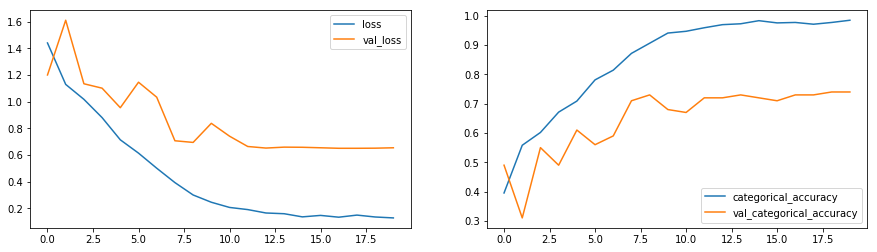

In [21]:
## Adam as optimizer

# Cleanup keras sessions
cleanup_keras_session()

optimizer_used = Adam()
# Build model
model_conv2d_lstm_4cl = conv2d_lstm_4cl(input_shape, nb_classes)

# Train model
history_conv2d_lstm_4cl = train_model(model_conv2d_lstm_4cl, batch_size, num_epochs, 
                                                         train_generator, val_generator, 
                                                      model_full_name='adam_conv2d_lstm_4cl',
                                                      optimizer_used = optimizer_used)

# Plot model - train and validation history - loss and accuracy curves
plot_model_history(history_conv2d_lstm_4cl)

### Model 1 (B) - conv2d_lstm_4cl with AdaBound as optimizer

`Conv2D - 4 layers (Neurons - 16/32/64/128) + LSTM + AdaBound (optimizer) + Filter (3,3) + Strides (2,2)`

`Model saved - Size: 8.71 MB - (https://drive.google.com/file/d/1eR4gbP65ytasPGyn9R8IiwItQn65gdGh/view?usp=sharing)`

- 18th Epoch

- Loss - 0.3664
- Categorical Accuracy - 0.9070

- Val Loss - 0.7163
- Val Categorical Accuracy - 0.6700


#### `Comments:`
##### `Bad model. Loss is bit high and validation accuracy is low.`

Keras Session Cleaned up...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 60, 60, 16)    448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 60, 60, 16)    64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 30, 30, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 30, 30, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 15, 15, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 15, 15, 

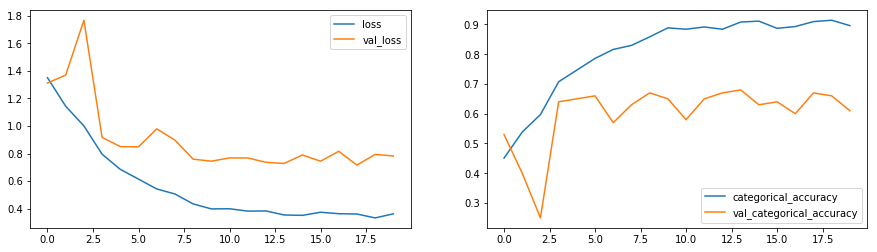

In [22]:
## AdaBound as optimizer

# Cleanup keras sessions
cleanup_keras_session()

optimizer_used = AdaBound()
# Build model
model_conv2d_lstm_4cl = conv2d_lstm_4cl(input_shape, nb_classes)

# Train model
history_conv2d_lstm_4cl = train_model(model_conv2d_lstm_4cl, batch_size, num_epochs, 
                                                         train_generator, val_generator, 
                                                      model_full_name='adabound_conv2d_lstm_4cl',
                                                      optimizer_used = optimizer_used)

# Plot model - train and validation history - loss and accuracy curves
plot_model_history(history_conv2d_lstm_4cl)

### Model 1 (C) - conv2d_lstm_4cl with SGD as optimizer

`Conv2D - 4 layers (Neurons - 16/32/64/128) + LSTM + SGD (optimizer) + Filter (3,3) + Strides (2,2)`

`Model saved - Size: 5.82 MB - (https://drive.google.com/file/d/1oELfA8J0SwtvcYWr-6jPoigjRM0KOoYy/view?usp=sharing)`

- 20th Epoch

- Loss - 0.1711
- Categorical Accuracy - 0.9731

- Val Loss - 0.6679
- Val Categorical Accuracy - 0.7400


#### `Comments:`
##### `Bad model. Loss is bit high and validation accuracy is low.`

Keras Session Cleaned up...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 60, 60, 16)    448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 60, 60, 16)    64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 30, 30, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 30, 30, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 15, 15, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 15, 15, 

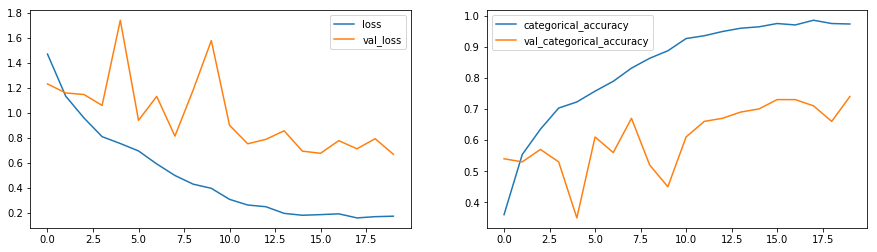

In [23]:
## SGD as optimizer

# Cleanup keras sessions
cleanup_keras_session()

optimizer_used = SGD(lr=0.01, clipvalue=1.0)
# Build model
model_conv2d_lstm_4cl = conv2d_lstm_4cl(input_shape, nb_classes)

# Train model
history_conv2d_lstm_4cl = train_model(model_conv2d_lstm_4cl, batch_size, num_epochs, 
                                                         train_generator, val_generator, 
                                                      model_full_name='sgd_conv2d_lstm_4cl',
                                                      optimizer_used = optimizer_used)

# Plot model - train and validation history - loss and accuracy curves
plot_model_history(history_conv2d_lstm_4cl)

### Based on above 3 models, we decided to use Adam as default optimizer for rest of the models. 

### With Adam as optimizer, we have achieved low loss / val loss and good categorical accuracy / val categorical accuracy.

### Model 2 - conv2d_lstm_4cl_dropouts

`Conv2D - 4 layers (Neurons - 16/32/64/128) + Dropouts + LSTM + Filter (3,3) + Strides (2,2)`. Dropouts used after every convolutional layer.

`Model saved - Size: 8.71 MB - (https://drive.google.com/file/d/1FVH0V3YUkI4xYv8s5TvL-tkdFllgzZxy/view?usp=sharing)`

- 20th Epoch

- Loss - 0.3163
- Categorical Accuracy - 0.8921

- Val Loss - 0.6778
- Val Categorical Accuracy - 0.7400

#### `Comments:`
##### `Bad model. Loss is bit high and validation accuracy is low.`

Keras Session Cleaned up...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 60, 60, 16)    448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 60, 60, 16)    64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 30, 30, 16)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 30, 30, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 30, 30, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 15, 15, 

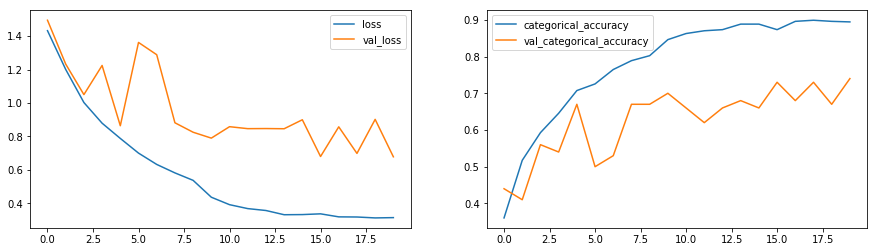

In [24]:
# Cleanup keras sessions
cleanup_keras_session()

# Build model
model_conv2d_lstm_4cl_dropouts = conv2d_lstm_4cl_dropouts(input_shape, nb_classes)

# Train model
history_conv2d_lstm_4cl_dropouts = train_model(model_conv2d_lstm_4cl_dropouts, batch_size, num_epochs, 
                                                         train_generator, val_generator, 
                                                      model_full_name='conv2d_lstm_4cl_dropouts')

# Plot model - train and validation history - loss and accuracy curves
plot_model_history(history_conv2d_lstm_4cl_dropouts)

### Model 3 - conv2d_lstm_4cl_filter

`Conv2D - 4 layers (Neurons - 16/32/64/128) + LSTM + Filter (1,1)`

`Model saved - Size: 37.7 MB - (https://drive.google.com/file/d/1zInJcf6fRrkLjNAT255fUObgxwvZE2oO/view?usp=sharing)`

- 17th Epoch

- Loss - 0.1688
- Categorical Accuracy - 0.9637

- Val Loss - 0.5379
- Val Categorical Accuracy - 0.7900


#### `Comments:`
##### `Not a good model in comparison to model 5. Loss is bit high and validation accuracy is low.`

Keras Session Cleaned up...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 60, 60, 32)    544       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 30, 30, 

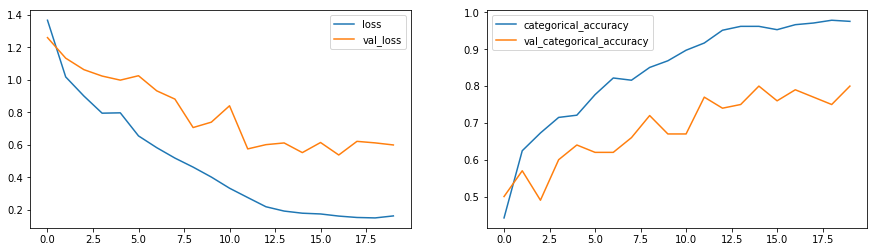

In [25]:
# Cleanup keras sessions
cleanup_keras_session()

# Build model
model_conv2d_lstm_4cl_filter = conv2d_lstm_4cl_filter(input_shape, nb_classes)

# Train model
history_conv2d_lstm_4cl_filter = train_model(model_conv2d_lstm_4cl_filter, batch_size, num_epochs, 
                                                         train_generator, val_generator, 
                                                      model_full_name='conv2d_lstm_4cl_filter')

# Plot model - train and validation history - loss and accuracy curves
plot_model_history(history_conv2d_lstm_4cl_filter)

### Model 4 - conv2d_lstm_4cl_filter_l2_regularizer

`Conv2D - 4 layers (Neurons - 16/32/64/128) + LSTM + Filter (1,1) + L2 Regularizer`

`Model saved - Size: 37.9 MB - (https://drive.google.com/file/d/1AUmLyDvnuXge3Nyk1HNkw9lcqsWGoUNp/view?usp=sharing)`

- 20th Epoch

- Loss - 1.1496
- Categorical Accuracy - 0.7428

- Val Loss - 1.3266
- Val Categorical Accuracy - 0.6700


#### `Comments:`
##### `Bad model. Loss is high and accuracy is low.`

Keras Session Cleaned up...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 60, 60, 32)    544       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 30, 30, 

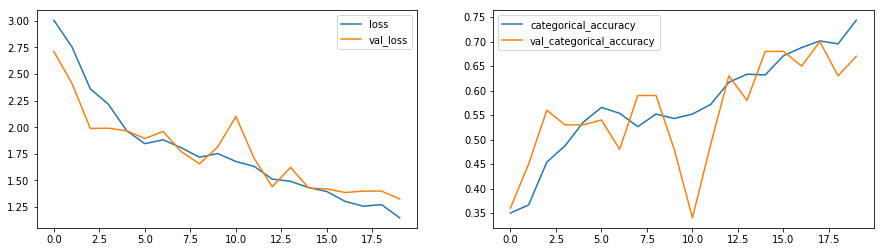

In [26]:
# Cleanup keras sessions
cleanup_keras_session()

# Build model
model_conv2d_lstm_4cl_filter_l2_regularizer = conv2d_lstm_4cl_filter_l2_regularizer(input_shape, nb_classes)

# Train model
history_conv2d_lstm_4cl_filter_l2_regularizer = train_model(model_conv2d_lstm_4cl_filter_l2_regularizer, batch_size, 
                                                                 num_epochs, train_generator, val_generator, 
                                                                 model_full_name='conv2d_lstm_4cl_filter_l2_regularizer')

# Plot model - train and validation history - loss and accuracy curves
plot_model_history(history_conv2d_lstm_4cl_filter_l2_regularizer)

### Model 5 - conv2d_lstm_5cl_filter

`Conv2D - 5 layers (Neurons - 16/32/64/128/256) + LSTM + Filter (1,1)`

`Model saved - Size: 30.6 MB - (https://drive.google.com/file/d/1iMQsFVTfUeTtoIXjtVYc0nsxV-iFHfc2/view?usp=sharing)`

- 13th Epoch

- Loss - 0.1200
- Categorical Accuracy - 0.9806

- Val Loss - 0.4473
- Val Categorical Accuracy - 0.8600


#### `Comments:`
##### `Quite a good model. Loss is low and accuracy is high. Validation accuracy is also comparable.`

Keras Session Cleaned up...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 60, 60, 32)    544       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 30, 30, 

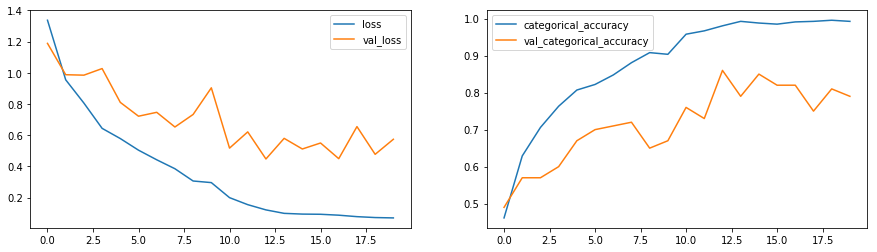

In [27]:
# Cleanup keras sessions
cleanup_keras_session()

# Build model
model_conv2d_lstm_5cl_filter = conv2d_lstm_5cl_filter(input_shape, nb_classes)

# Train model
history_conv2d_lstm_5cl_filter = train_model(model_conv2d_lstm_5cl_filter, batch_size, 
                                                                 num_epochs, train_generator, val_generator, 
                                                                 model_full_name='conv2d_lstm_5cl_filter')

# Plot model - train and validation history - loss and accuracy curves
plot_model_history(history_conv2d_lstm_5cl_filter)

### Model 6 - conv2d_lstm_5cl_filter_l2_regularizer - 30 epochs

`Conv2D - 5 layers (Neurons - 16/32/64/128/256) + LSTM + Filter (1,1) + L2 Regularizer`

`Model saved - Size: 31.4 MB - (https://drive.google.com/file/d/1IeLO3PnmPcozIYTM_hkUb2G6zr-Zg4JZ/view?usp=sharing)`

- 20th Epoch

- Loss - 0.9676
- Categorical Accuracy - 0.9025

- Val Loss - 1.1560
- Val Categorical Accuracy - 0.8200


#### `Comments:`
##### `Not a good model in comparison to model 5. Loss is high.`
##### `Please notice that after 20 epochs, there was no improvement in validation loss as explained earlier.`

Keras Session Cleaned up...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 60, 60, 32)    544       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 30, 30, 

Epoch 17/30
67/67 [==============================] - 88s 1s/step - loss: 1.0993 - categorical_accuracy: 0.8433 - val_loss: 1.2479 - val_categorical_accuracy: 0.7900

Epoch 00017: val_loss improved from 1.28602 to 1.24791, saving model to model_conv2d_lstm_5cl_filter_l2_regularizer/conv2d_lstm_5cl_filter_l2_regularizer_best_model.h5
Epoch 18/30
67/67 [==============================] - 83s 1s/step - loss: 1.0672 - categorical_accuracy: 0.8612 - val_loss: 1.3678 - val_categorical_accuracy: 0.7300

Epoch 00018: val_loss did not improve from 1.24791
Epoch 19/30
67/67 [==============================] - 85s 1s/step - loss: 1.0073 - categorical_accuracy: 0.8761 - val_loss: 1.2926 - val_categorical_accuracy: 0.7800

Epoch 00019: val_loss did not improve from 1.24791

Epoch 00019: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
Epoch 20/30
67/67 [==============================] - 83s 1s/step - loss: 0.9676 - categorical_accuracy: 0.9025 - val_loss: 1.1560 - val_categorical_ac

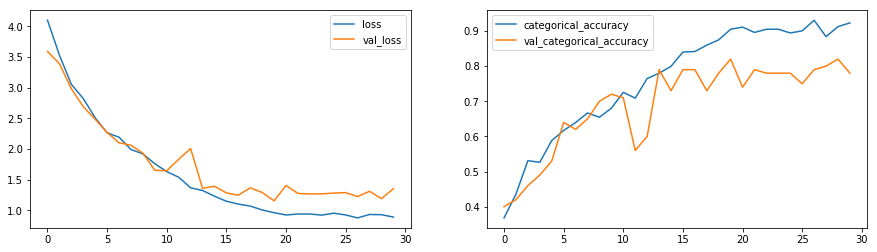

In [28]:
# Cleanup keras sessions
cleanup_keras_session()

# Build model
model_conv2d_lstm_5cl_filter_l2_regularizer = conv2d_lstm_5cl_filter_l2_regularizer(input_shape, nb_classes)

# Train model
history_conv2d_lstm_5cl_filter_l2_regularizer = train_model(model_conv2d_lstm_5cl_filter_l2_regularizer, batch_size, 
                                                                 30, train_generator, val_generator, 
                                                                 model_full_name='conv2d_lstm_5cl_filter_l2_regularizer')

# Plot model - train and validation history - loss and accuracy curves
plot_model_history(history_conv2d_lstm_5cl_filter_l2_regularizer)

### Model 7 - conv2d_lstm_6cl_filter

`Conv2D - 6 layers (Neurons - 16/32/64/128/256/256) + LSTM + Filter (1,1)`

`Model saved - Size: 7.41 MB - (https://drive.google.com/file/d/1yyYLD8FQCRIiyWMytUX-qkvecO01vzTa/view?usp=sharing)`

- 11th Epoch

- Loss - 0.5187
- Categorical Accuracy - 0.8149

- Val Loss - 0.6837
- Val Categorical Accuracy - 0.7800


#### `Comments:`
##### `Not a good model in comparison to model 5. Loss is bit high and accuracy is bit low.`

Keras Session Cleaned up...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 60, 60, 32)    544       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 30, 30, 

67/67 [==============================] - 88s 1s/step - loss: 0.2945 - categorical_accuracy: 0.9179 - val_loss: 0.6882 - val_categorical_accuracy: 0.7600

Epoch 00019: val_loss did not improve from 0.68373

Epoch 00019: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.
Epoch 20/20
67/67 [==============================] - 87s 1s/step - loss: 0.3287 - categorical_accuracy: 0.9015 - val_loss: 0.6899 - val_categorical_accuracy: 0.7600

Epoch 00020: val_loss did not improve from 0.68373


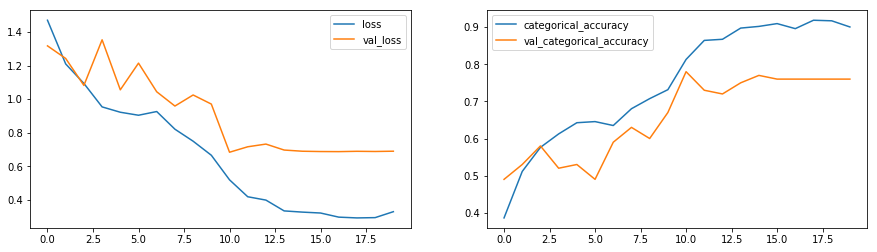

In [18]:
# Cleanup keras sessions
cleanup_keras_session()

# Build model
model_conv2d_lstm_6cl_filter = conv2d_lstm_6cl_filter(input_shape, nb_classes)

# Train model
history_conv2d_lstm_6cl_filter = train_model(model_conv2d_lstm_6cl_filter, batch_size, 
                                                                 num_epochs, train_generator, val_generator, 
                                                                 model_full_name='conv2d_lstm_6cl_filter')

# Plot model - train and validation history - loss and accuracy curves
plot_model_history(history_conv2d_lstm_6cl_filter)

## `GRU Based Models`

### Model 8 - conv2d_gru_4cl

`Conv2D - 4 layers (Neurons - 16/32/64/128) + GRU + Filter (3,3) + Strides (2,2)`

`Model saved - Size: 6.83 MB - (https://drive.google.com/file/d/1CtAze2s8SKZ4XZ21_2J_jEzv3cOLA0ir/view?usp=sharing)`

- 7th Epoch

- Loss - 0.2087
- Categorical Accuracy - 0.9369

- Val Loss - 0.6504
- Val Categorical Accuracy - 0.7400


#### `Comments:`
##### `Bad model. Loss is bit high and validation accuracy is low.`

Keras Session Cleaned up...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 60, 60, 16)    448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 60, 60, 16)    64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 30, 30, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 30, 30, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 15, 15, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 15, 15, 

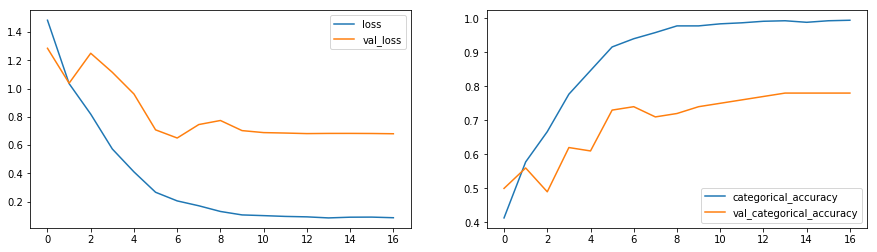

In [29]:
# Cleanup keras sessions
cleanup_keras_session()

# Build model
model_conv2d_gru_4cl = conv2d_gru_4cl(input_shape, nb_classes)

# Train model
history_conv2d_gru_4cl = train_model(model_conv2d_gru_4cl, batch_size, num_epochs, 
                                                         train_generator, val_generator, 
                                                      model_full_name='conv2d_gru_4cl')

# Plot model - train and validation history - loss and accuracy curves
plot_model_history(history_conv2d_gru_4cl)

### Model 9 - conv2d_gru_4cl_dropouts

`Conv2D - 4 layers (Neurons - 16/32/64/128) + Dropouts + GRU + Filter (3,3) + Strides (2,2)`. Dropouts used after every convolutional layer.

`Model saved - Size: 6.84 MB - (https://drive.google.com/file/d/1fUZ9BD0YiyFavvP8gNgnoDcyKaLos5Pb/view?usp=sharing)`

- 4th Epoch

- Loss - 0.9201
- Categorical Accuracy - 0.6438

- Val Loss - 0.8932
- Val Categorical Accuracy - 0.6900

#### `Comments:`
##### `Bad model. Loss is high and accuracy is low.`

Keras Session Cleaned up...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 60, 60, 16)    448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 60, 60, 16)    64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 30, 30, 16)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 30, 30, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 30, 30, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 15, 15, 

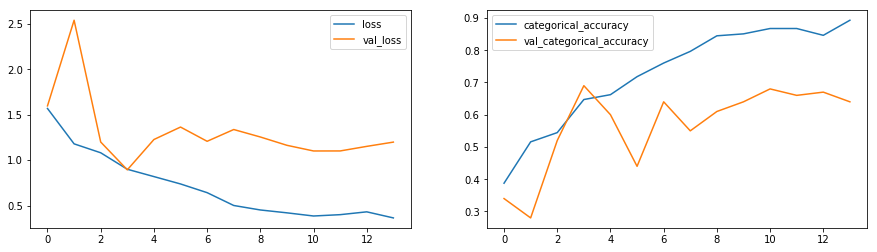

In [30]:
# Cleanup keras sessions
cleanup_keras_session()

# Build model
model_conv2d_gru_4cl_dropouts = conv2d_gru_4cl_dropouts(input_shape, nb_classes)

# Train model
history_conv2d_gru_4cl_dropouts = train_model(model_conv2d_gru_4cl_dropouts, batch_size, num_epochs, 
                                                         train_generator, val_generator, 
                                                      model_full_name='conv2d_gru_4cl_dropouts')

# Plot model - train and validation history - loss and accuracy curves
plot_model_history(history_conv2d_gru_4cl_dropouts)

### Model 10 - conv2d_gru_4cl_filter

`Conv2D - 4 layers (Neurons - 16/32/64/128) + GRU + Filter (1,1)`

`Model saved - Size: 28.3 MB - (https://drive.google.com/file/d/1-BIUC0GYe0E6y4aXHFDO3QfkPtUaWx7R/view?usp=sharing)`

- 18th Epoch

- Loss - 0.1479
- Categorical Accuracy - 0.9622

- Val Loss - 0.4118
- Val Categorical Accuracy - 0.8300


#### `Comments:`
##### `Model is good. Loss is low. Accuracy is good and validation accuracy is comparable.`

Keras Session Cleaned up...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 60, 60, 32)    544       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 30, 30, 

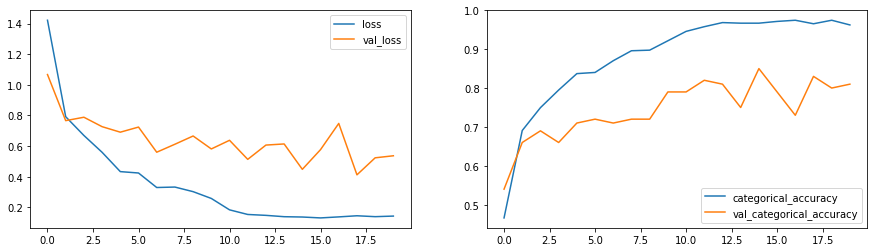

In [31]:
# Cleanup keras sessions
cleanup_keras_session()

# Build model
model_conv2d_gru_4cl_filter = conv2d_gru_4cl_filter(input_shape, nb_classes)

# Train model
history_conv2d_gru_4cl_filter = train_model(model_conv2d_gru_4cl_filter, batch_size, num_epochs, 
                                                         train_generator, val_generator,
                                                      model_full_name='conv2d_gru_4cl_filter')

# Plot model - train and validation history - loss and accuracy curves
plot_model_history(history_conv2d_gru_4cl_filter)

### Model 11 - conv2d_gru_4cl_filter_l2_regularizer

`Conv2D - 4 layers (Neurons - 16/32/64/128) + GRU + Filter (1,1) + L2 Regularizer`

`Model saved - Size: 28.5 MB - (https://drive.google.com/file/d/1NILyALTP9U0xtC8C1I7uhsh8Hu4gXOt5/view?usp=sharing)`

- 20th Epoch

- Loss - 1.1798
- Categorical Accuracy - 0.7797

- Val Loss - 1.1083
- Val Categorical Accuracy - 0.8200


#### `Comments:`
##### `Not a good model in comparison to model 12. Loss is high and accuracy is low.`

Keras Session Cleaned up...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 60, 60, 32)    544       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 30, 30, 

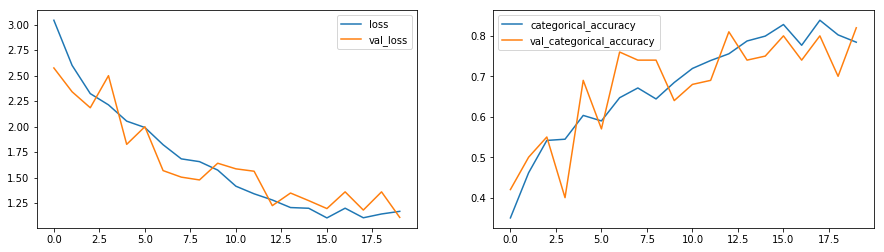

In [32]:
# Cleanup keras sessions
cleanup_keras_session()

# Build model
model_conv2d_gru_4cl_filter_l2_regularizer = conv2d_gru_4cl_filter_l2_regularizer(input_shape, nb_classes)

# Train model
history_conv2d_gru_4cl_filter_l2_regularizer = train_model(model_conv2d_gru_4cl_filter_l2_regularizer, batch_size, num_epochs, 
                                                         train_generator, val_generator,
                                                      model_full_name='conv2d_gru_4cl_filter_l2_regularizer')

# Plot model - train and validation history - loss and accuracy curves
plot_model_history(history_conv2d_gru_4cl_filter_l2_regularizer)

### Model 12 - conv2d_gru_5cl_filter

`Conv2D - 5 layers (Neurons - 16/32/64/128/256) + GRU + Filter (1,1)`

`Model saved - Size: 23.1 MB - (https://drive.google.com/file/d/1aqo2mkTjvMxOWEJfto3DwfnAGbq8BRzS/view?usp=sharing)`

- 19th Epoch

- Loss - 0.0627
- Categorical Accuracy - 0.9881

- Val Loss - 0.3441
- Val Categorical Accuracy - 0.81


#### `Comments:`
##### `Quite a good model. Loss is low and accuracy is high. Validation accuracy is relatively ok (above 80%).`

Keras Session Cleaned up...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 60, 60, 32)    544       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 30, 30, 

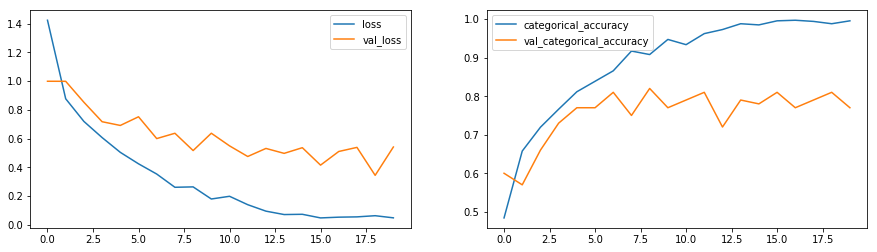

In [33]:
# Cleanup keras sessions
cleanup_keras_session()

# Build model
model_conv2d_gru_5cl_filter = conv2d_gru_5cl_filter(input_shape, nb_classes)

# Train model
history_conv2d_gru_5cl_filter = train_model(model_conv2d_gru_5cl_filter, batch_size, num_epochs, 
                                                         train_generator, val_generator,
                                                      model_full_name='conv2d_gru_5cl_filter')

# Plot model - train and validation history - loss and accuracy curves
plot_model_history(history_conv2d_gru_5cl_filter)

### Model 13 - conv2d_gru_5cl_filter_l2_regularizer - 30 epochs

`Conv2D - 5 layers (Neurons - 16/32/64/128/256) + GRU + Filter (1,1) + L2 Regularizer`

`Model saved - Size: 23.9 MB - (https://drive.google.com/file/d/10FDSn2iX0J_509hZxhpp9wzKXUi6MHSr/view?usp=sharing)`

- 30th Epoch

- Loss - 1.0370
- Categorical Accuracy - 0.9006

- Val Loss - 1.2440
- Val Categorical Accuracy - 0.8200


#### `Comments:`
##### `Not a good model in comparison to model 12. Loss is high.`
##### `Please notice that there is not much improvement between 20th to 30th Epoch as explained earlier.`

Keras Session Cleaned up...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 60, 60, 32)    544       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 30, 30, 

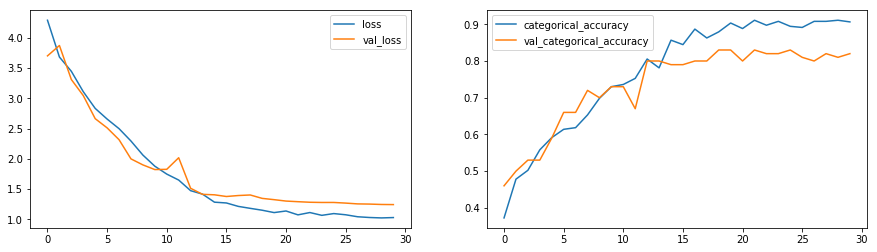

In [11]:
# Cleanup keras sessions
cleanup_keras_session()

# Build model
model_conv2d_gru_5cl_filter_l2_regularizer = conv2d_gru_5cl_filter_l2_regularizer(input_shape, nb_classes)

# Train model
history_conv2d_gru_5cl_filter_l2_regularizer = train_model(model_conv2d_gru_5cl_filter_l2_regularizer, batch_size, 30, 
                                                         train_generator, val_generator,
                                                      model_full_name='conv2d_gru_5cl_filter_l2_regularizer')

# Plot model - train and validation history - loss and accuracy curves
plot_model_history(history_conv2d_gru_5cl_filter_l2_regularizer)

### Model 14 - conv2d_gru_6cl_filter

`Conv2D - 6 layers (Neurons - 16/32/64/128/256/256) + GRU + Filter (1,1)`

`Model saved - Size: 5.91 MB - (https://drive.google.com/file/d/1QsBBfEXg2XSFvfAyiwHe_t7C32VBOFc0/view?usp=sharing)`

- 15th Epoch

- Loss - 0.2263
- Categorical Accuracy - 0.9507

- Val Loss - 0.6850
- Val Categorical Accuracy - 0.7300


#### `Comments:`
##### `Not a good model in comparison to model 12. Loss is bit high and validation accuracy is low.`

Keras Session Cleaned up...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 60, 60, 32)    544       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 30, 30, 

67/67 [==============================] - 83s 1s/step - loss: 0.2511 - categorical_accuracy: 0.9254 - val_loss: 0.7569 - val_categorical_accuracy: 0.7100

Epoch 00020: val_loss did not improve from 0.68500


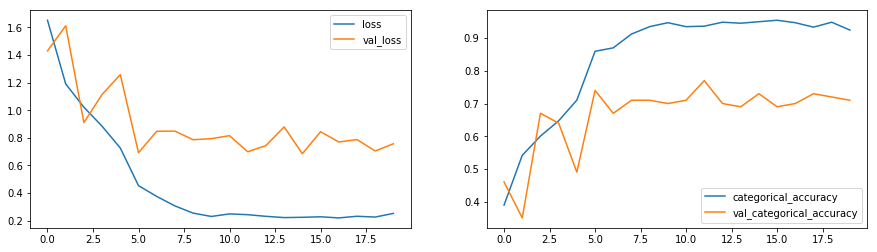

In [19]:
# Cleanup keras sessions
cleanup_keras_session()

# Build model
model_conv2d_gru_6cl_filter = conv2d_gru_6cl_filter(input_shape, nb_classes)

# Train model
history_conv2d_gru_6cl_filter = train_model(model_conv2d_gru_6cl_filter, batch_size, num_epochs, 
                                                         train_generator, val_generator,
                                                      model_full_name='conv2d_gru_6cl_filter')

# Plot model - train and validation history - loss and accuracy curves
plot_model_history(history_conv2d_gru_6cl_filter)

## `Conv3D Based Models`

### Model 15 - conv3d_4cl

`Conv3D - 4 layers (Neurons - 16/32/64/128) + Filter (3,3,3)`

`Model saved - Size: 12.8 MB - (https://drive.google.com/file/d/1xhyHjHmueMXFhpLeucrFH2n2n96Q3m-y/view?usp=sharing)`

- 17th Epoch

- Loss - 0.4414
- Categorical Accuracy - 0.8313

- Val Loss - 0.5673
- Val Categorical Accuracy - 0.8000


#### `Comments:`
##### `Not a good model in comparison to model 23 and 25. Loss is bit high and accuracy is bit low.`

Keras Session Cleaned up...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 


Epoch 00018: val_loss did not improve from 0.56733
Epoch 19/20
67/67 [==============================] - 83s 1s/step - loss: 0.4698 - categorical_accuracy: 0.8225 - val_loss: 0.5745 - val_categorical_accuracy: 0.8000

Epoch 00019: val_loss did not improve from 0.56733

Epoch 00019: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
Epoch 20/20
67/67 [==============================] - 83s 1s/step - loss: 0.4556 - categorical_accuracy: 0.8409 - val_loss: 0.5698 - val_categorical_accuracy: 0.7700

Epoch 00020: val_loss did not improve from 0.56733


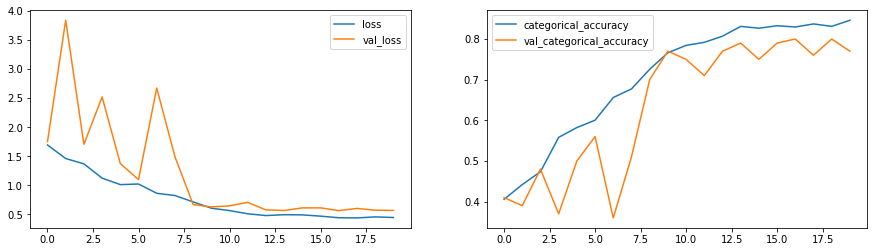

In [12]:
# Cleanup keras sessions
cleanup_keras_session()

# Build model
model_conv3d_4cl = conv3d_4cl(input_shape, nb_classes)

# Train model
history_conv3d_4cl = train_model(model_conv3d_4cl, batch_size, num_epochs, train_generator, val_generator,
                                 model_full_name='conv3d_4cl')

# Plot model - train and validation history - loss and accuracy curves
plot_model_history(history_conv3d_4cl)

### Model 16 - conv3d_4cl_dropouts

`Conv3D - 4 layers (Neurons - 16/32/64/128) + Dropouts + Filter (3,3,3)`. Dropouts used after every convolutional layer.

`Model saved - Size: 12.8 MB - (https://drive.google.com/file/d/1MA-antE0PomzNg9_iurKaNPUP7yuecr3/view?usp=sharing)`

- 3rd Epoch

- Loss - 1.2867
- Categorical Accuracy - 0.5099

- Val Loss - 1.2558
- Val Categorical Accuracy - 0.5000


#### `Comments:`
##### `Bad model. Loss is high and accuracy is low.`

Keras Session Cleaned up...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 

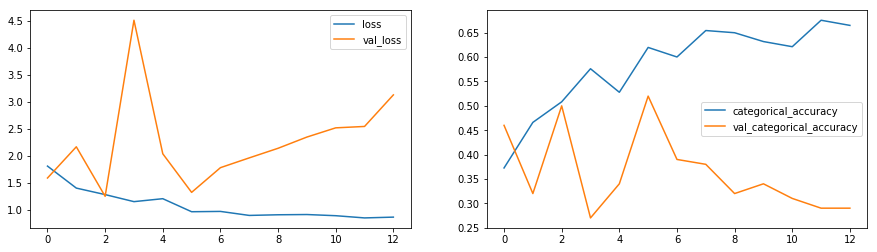

In [13]:
# Cleanup keras sessions
cleanup_keras_session()

# Build model
model_conv3d_4cl_dropouts = conv3d_4cl_dropouts(input_shape, nb_classes)

# Train model
history_conv3d_4cl_dropouts = train_model(model_conv3d_4cl_dropouts, batch_size, num_epochs, 
                                                         train_generator, val_generator,
                                                      model_full_name='conv3d_4cl_dropouts')

# Plot model - train and validation history - loss and accuracy curves
plot_model_history(history_conv3d_4cl_dropouts)

### Model 17 - conv3d_4cl_l2_regularizer

`Conv3D - 4 layers (Neurons - 16/32/64/128) + Filter (3,3,3) + L2 Regularizer`

`Model saved - Size: 12.8 MB - (https://drive.google.com/file/d/1ilSs7rsh6BhlI4t3n_M6MJPYpE_xX2la/view?usp=sharing)`

- 19th Epoch

- Loss - 2.4142
- Categorical Accuracy - 0.8548

- Val Loss - 2.4841
- Val Categorical Accuracy - 0.8700


#### `Comments:`
##### `Not a good model in comparison to model 23 and 25. Loss is high.`

Keras Session Cleaned up...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 

67/67 [==============================] - 85s 1s/step - loss: 2.4241 - categorical_accuracy: 0.8742 - val_loss: 2.5675 - val_categorical_accuracy: 0.8300

Epoch 00018: val_loss did not improve from 2.52341
Epoch 19/20
67/67 [==============================] - 87s 1s/step - loss: 2.4142 - categorical_accuracy: 0.8548 - val_loss: 2.4841 - val_categorical_accuracy: 0.8700

Epoch 00019: val_loss improved from 2.52341 to 2.48408, saving model to model_conv3d_4cl_l2_regularizer/conv3d_4cl_l2_regularizer_best_model.h5
Epoch 20/20
67/67 [==============================] - 87s 1s/step - loss: 2.4361 - categorical_accuracy: 0.8652 - val_loss: 2.4983 - val_categorical_accuracy: 0.8900

Epoch 00020: val_loss did not improve from 2.48408


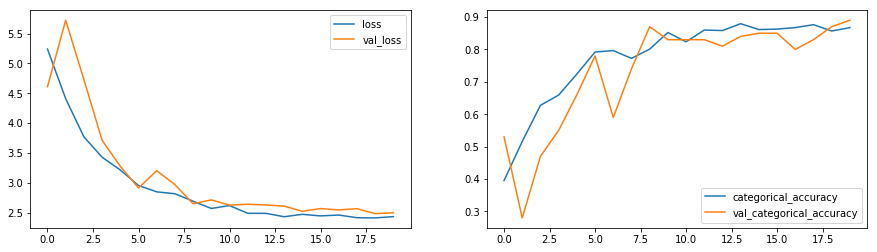

In [14]:
# Cleanup keras sessions
cleanup_keras_session()

# Build model
model_conv3d_4cl_l2_regularizer = conv3d_4cl_l2_regularizer(input_shape, nb_classes)

# Train model
history_conv3d_4cl_l2_regularizer = train_model(model_conv3d_4cl_l2_regularizer, batch_size, num_epochs, 
                                                         train_generator, val_generator,
                                                      model_full_name='conv3d_4cl_l2_regularizer')

# Plot model - train and validation history - loss and accuracy curves
plot_model_history(history_conv3d_4cl_l2_regularizer)

### Model 18 - conv3d_4cl_filter

`Conv3D - 4 layers (Neurons - 16/32/64/128) + Filter (1,1,1)`

`Model saved - Size: 9.62 MB - (https://drive.google.com/file/d/19nAdNrOH2oPBKWBZyQaZKacui8R32XlY/view?usp=sharing)`

- 6th Epoch

- Loss - 0.5503
- Categorical Accuracy - 0.7916

- Val Loss - 0.4442
- Val Categorical Accuracy - 0.8400


#### `Comments:`
##### `Bad model. Loss is bit high and accuracy is low.`

Keras Session Cleaned up...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 16)  64        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 32)    544       
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 

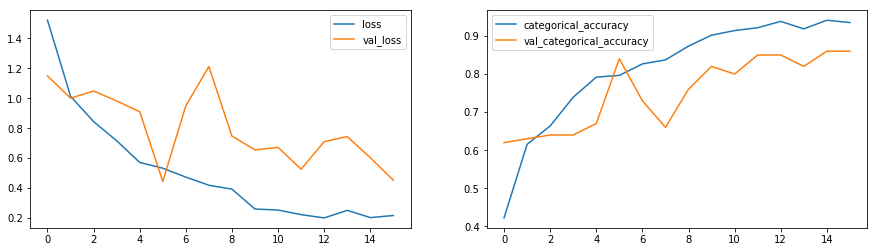

In [15]:
# Cleanup keras sessions
cleanup_keras_session()

# Build model
model_conv3d_4cl_filter = conv3d_4cl_filter(input_shape, nb_classes)

# Train model
history_conv3d_4cl_filter = train_model(model_conv3d_4cl_filter, batch_size, num_epochs, 
                                                         train_generator, val_generator, model_full_name='conv3d_4cl_filter')

# Plot model - train and validation history - loss and accuracy curves
plot_model_history(history_conv3d_4cl_filter)

### Model 19 - conv3d_4cl_filter_l2_regularizer

`Conv3D - 4 layers (Neurons - 16/32/64/128) + Filter (1,1,1) + L2 Regularizer`

`Model saved - Size: 9.62 MB - (https://drive.google.com/file/d/1h5Egs0I9SKb8eLnBVZVws4ODEK5zp2-u/view?usp=sharing)`

- 19th Epoch

- Loss - 1.5189
- Categorical Accuracy - 0.8746

- Val Loss - 1.6352
- Val Categorical Accuracy - 0.7600

#### `Comments:`
##### `Bad model. Loss is high and validation accuracy is low.`

Keras Session Cleaned up...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 16)  64        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 32)    544       
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 


Epoch 00016: val_loss improved from 2.13083 to 2.03964, saving model to model_conv3d_4cl_filter_l2_regularizer/conv3d_4cl_filter_l2_regularizer_best_model.h5
Epoch 17/20
67/67 [==============================] - 84s 1s/step - loss: 1.6523 - categorical_accuracy: 0.8880 - val_loss: 1.9652 - val_categorical_accuracy: 0.7900

Epoch 00017: val_loss improved from 2.03964 to 1.96521, saving model to model_conv3d_4cl_filter_l2_regularizer/conv3d_4cl_filter_l2_regularizer_best_model.h5
Epoch 18/20
67/67 [==============================] - 83s 1s/step - loss: 1.5830 - categorical_accuracy: 0.8701 - val_loss: 1.7922 - val_categorical_accuracy: 0.7500

Epoch 00018: val_loss improved from 1.96521 to 1.79222, saving model to model_conv3d_4cl_filter_l2_regularizer/conv3d_4cl_filter_l2_regularizer_best_model.h5
Epoch 19/20
67/67 [==============================] - 82s 1s/step - loss: 1.5189 - categorical_accuracy: 0.8746 - val_loss: 1.6352 - val_categorical_accuracy: 0.7600

Epoch 00019: val_loss impro

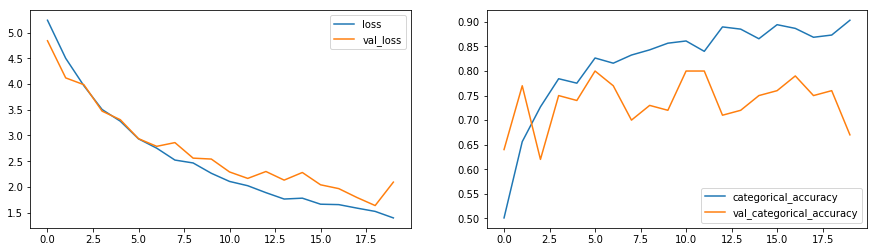

In [16]:
# Cleanup keras sessions
cleanup_keras_session()

# Build model
model_conv3d_4cl_filter_l2_regularizer = conv3d_4cl_filter_l2_regularizer(input_shape, nb_classes)

# Train model
history_conv3d_4cl_filter_l2_regularizer = train_model(model_conv3d_4cl_filter_l2_regularizer, batch_size, num_epochs, 
                                                         train_generator, val_generator,
                                                      model_full_name='conv3d_4cl_filter_l2_regularizer')

# Plot model - train and validation history - loss and accuracy curves
plot_model_history(history_conv3d_4cl_filter_l2_regularizer)

### Model 20 - conv3d_5cl

`Conv3D - 5 layers (Neurons - 16/32/64/128/256) + Filter (3,3,3)`

`Model saved - Size: 51.1 MB - (https://drive.google.com/file/d/1heTY6iBuI4caMb8T1-ugW7OqAvMhFsHm/view?usp=sharing)`

- 14th Epoch

- Loss - 0.6580
- Categorical Accuracy - 0.7438

- Val Loss - 0.7985
- Val Categorical Accuracy - 0.6600


#### `Comments:`
##### `Bad model. Loss is high and accuracy is low.`

Keras Session Cleaned up...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 

67/67 [==============================] - 85s 1s/step - loss: 0.5955 - categorical_accuracy: 0.7697 - val_loss: 0.8221 - val_categorical_accuracy: 0.6400

Epoch 00017: val_loss did not improve from 0.79846
Epoch 18/20
67/67 [==============================] - 82s 1s/step - loss: 0.5537 - categorical_accuracy: 0.7995 - val_loss: 0.8435 - val_categorical_accuracy: 0.6200

Epoch 00018: val_loss did not improve from 0.79846

Epoch 00018: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
Epoch 19/20
67/67 [==============================] - 86s 1s/step - loss: 0.6716 - categorical_accuracy: 0.7528 - val_loss: 0.8224 - val_categorical_accuracy: 0.6500

Epoch 00019: val_loss did not improve from 0.79846
Epoch 20/20
67/67 [==============================] - 82s 1s/step - loss: 0.6118 - categorical_accuracy: 0.7562 - val_loss: 0.8452 - val_categorical_accuracy: 0.6300

Epoch 00020: val_loss did not improve from 0.79846

Epoch 00020: ReduceLROnPlateau reducing learning rate to 3.20

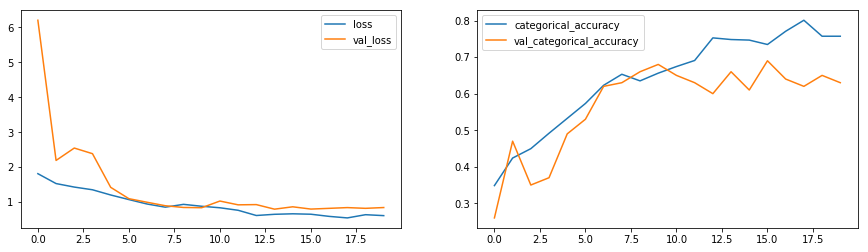

In [17]:
# Cleanup keras sessions
cleanup_keras_session()

# Build model
model_conv3d_5cl = conv3d_5cl(input_shape, nb_classes)

# Train model
history_conv3d_5cl = train_model(model_conv3d_5cl, batch_size, num_epochs, 
                                                         train_generator, val_generator,
                                                      model_full_name='conv3d_5cl')

# Plot model - train and validation history - loss and accuracy curves
plot_model_history(history_conv3d_5cl)

### Model 21 - conv3d_5cl_dropouts

`Conv3D - 5 layers (Neurons - 16/32/64/128/256) + Dropouts + Filter (3,3,3)`. Dropouts used after every convolutional layer.

`Model saved - Size: 51.1 MB - (https://drive.google.com/file/d/14cw0dHSToF0pt-aWhafWX6xR5Qv48Z_3/view?usp=sharing)`

- 11th Epoch

- Loss - 0.6189
- Categorical Accuracy - 0.7716

- Val Loss - 1.3617
- Val Categorical Accuracy - 0.4200


#### `Comments:`
##### `Bad model. Loss is high and accuracy is low.`

Keras Session Cleaned up...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 


Epoch 00014: val_loss did not improve from 1.36166
Epoch 15/20
67/67 [==============================] - 85s 1s/step - loss: 0.4642 - categorical_accuracy: 0.8328 - val_loss: 1.5794 - val_categorical_accuracy: 0.5000

Epoch 00015: val_loss did not improve from 1.36166

Epoch 00015: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
Epoch 16/20
67/67 [==============================] - 85s 1s/step - loss: 0.4569 - categorical_accuracy: 0.8239 - val_loss: 1.5843 - val_categorical_accuracy: 0.5000

Epoch 00016: val_loss did not improve from 1.36166
Epoch 17/20
67/67 [==============================] - 83s 1s/step - loss: 0.4419 - categorical_accuracy: 0.8328 - val_loss: 1.6310 - val_categorical_accuracy: 0.4900

Epoch 00017: val_loss did not improve from 1.36166

Epoch 00017: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
Epoch 18/20
67/67 [==============================] - 85s 1s/step - loss: 0.5066 - categorical_accuracy: 0.8149 - val_loss: 1.6247 - va

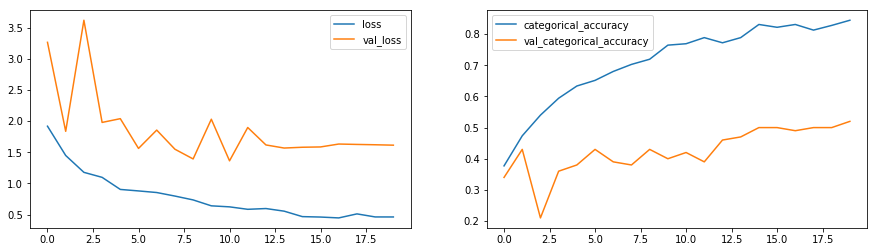

In [18]:
# Cleanup keras sessions
cleanup_keras_session()

# Build model
model_conv3d_5cl_dropouts = conv3d_5cl_dropouts(input_shape, nb_classes)

# Train model
history_conv3d_5cl_dropouts = train_model(model_conv3d_5cl_dropouts, batch_size, num_epochs, 
                                                         train_generator, val_generator,
                                                      model_full_name='conv3d_5cl_dropouts')

# Plot model - train and validation history - loss and accuracy curves
plot_model_history(history_conv3d_5cl_dropouts)

### Model 22 - conv3d_5cl_l2_regularizer

`Conv3D - 5 layers (Neurons - 16/32/64/128/256) + Filter (3,3,3) + L2 Regularizer`

`Model saved - Size: 51.1 MB - (https://drive.google.com/file/d/1xcR7ACK4fUi0KSZya1XxCSzsMLdxvZzy/view?usp=sharing)`

- 19th Epoch

- Loss - 2.2079
- Categorical Accuracy - 0.8742

- Val Loss - 2.3546
- Val Categorical Accuracy - 0.8100


#### `Comments:`
##### `Not a good model in comparison to model 23 and 25. Loss is high.`

Keras Session Cleaned up...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 

Epoch 16/20
67/67 [==============================] - 85s 1s/step - loss: 2.7525 - categorical_accuracy: 0.8119 - val_loss: 2.8725 - val_categorical_accuracy: 0.7700

Epoch 00016: val_loss improved from 3.08786 to 2.87252, saving model to model_conv3d_5cl_l2_regularizer/conv3d_5cl_l2_regularizer_best_model.h5
Epoch 17/20
67/67 [==============================] - 89s 1s/step - loss: 2.5281 - categorical_accuracy: 0.8537 - val_loss: 2.6610 - val_categorical_accuracy: 0.7800

Epoch 00017: val_loss improved from 2.87252 to 2.66101, saving model to model_conv3d_5cl_l2_regularizer/conv3d_5cl_l2_regularizer_best_model.h5
Epoch 18/20
67/67 [==============================] - 83s 1s/step - loss: 2.3482 - categorical_accuracy: 0.8562 - val_loss: 2.4685 - val_categorical_accuracy: 0.8000

Epoch 00018: val_loss improved from 2.66101 to 2.46849, saving model to model_conv3d_5cl_l2_regularizer/conv3d_5cl_l2_regularizer_best_model.h5
Epoch 19/20
67/67 [==============================] - 87s 1s/step - los

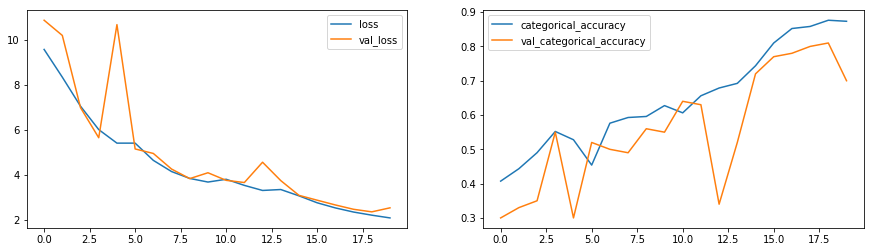

In [19]:
# Cleanup keras sessions
cleanup_keras_session()

# Build model
model_conv3d_5cl_l2_regularizer = conv3d_5cl_l2_regularizer(input_shape, nb_classes)

# Train model
history_conv3d_5cl_l2_regularizer = train_model(model_conv3d_5cl_l2_regularizer, batch_size, num_epochs, 
                                                         train_generator, val_generator,
                                                      model_full_name='conv3d_5cl_l2_regularizer')

# Plot model - train and validation history - loss and accuracy curves
plot_model_history(history_conv3d_5cl_l2_regularizer)

### Model 23 - conv3d_5cl_filter

`Conv3D - 5 layers (Neurons - 16/32/64/128/256) + Filter (1,1,1)`

`Model saved - Size: 38.1 MB - (https://drive.google.com/file/d/1CQqEAJHs4IpxANIoOhSUJCXh-A1lbyUP/view?usp=sharing)`

- 8th Epoch

- Loss - 0.2612
- Categorical Accuracy - 0.9181

- Val Loss - 0.3557
- Val Categorical Accuracy - 0.9100


#### `Comments:`
##### `A very good model. Low loss and very high accuracy. Validation accuracy is almost same.`
##### `Though best model was at 8th epoch, loss and accuracies kept oscillating in rest of epochs but did not go worse.`

Keras Session Cleaned up...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 16)  64        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 32)    544       
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 

67/67 [==============================] - 82s 1s/step - loss: 0.1860 - categorical_accuracy: 0.9388 - val_loss: 0.4014 - val_categorical_accuracy: 0.9000

Epoch 00017: val_loss did not improve from 0.35572
Epoch 18/20
67/67 [==============================] - 86s 1s/step - loss: 0.1760 - categorical_accuracy: 0.9548 - val_loss: 0.4644 - val_categorical_accuracy: 0.8600

Epoch 00018: val_loss did not improve from 0.35572

Epoch 00018: ReduceLROnPlateau reducing learning rate to 1.2800001059076749e-08.
Epoch 00018: early stopping


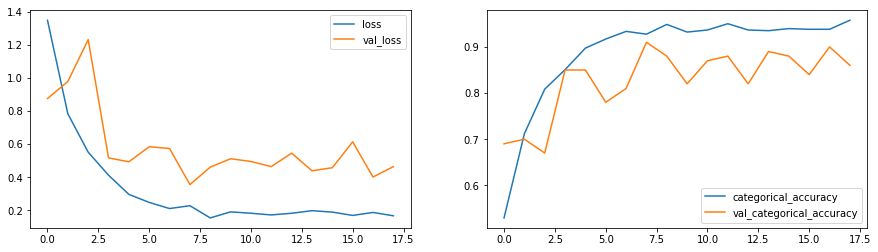

In [20]:
# Cleanup keras sessions
cleanup_keras_session()

# Build model
model_conv3d_5cl_filter = conv3d_5cl_filter(input_shape, nb_classes)

# Train model
history_conv3d_5cl_filter = train_model(model_conv3d_5cl_filter, batch_size, num_epochs, 
                                                         train_generator, val_generator,
                                                      model_full_name='conv3d_5cl_filter')

# Plot model - train and validation history - loss and accuracy curves
plot_model_history(history_conv3d_5cl_filter)

### Model 24 - conv3d_5cl_filter_l2_regularizer

`Conv3D - 5 layers (Neurons - 16/32/64/128/256) + Filter (1,1,1) + L2 Regularizer`

`Model saved - Size: 38.1 MB - (https://drive.google.com/file/d/1dgUs1vdpLGlMbXOuIT0mt2OnPEdGU_AY/view?usp=sharing)`

- 20th Epoch

- Loss - 2.3258
- Categorical Accuracy - 0.9627

- Val Loss - 2.5665
- Val Categorical Accuracy - 0.8500


#### `Comments:`
##### `Not a good model in comparison to model 23 and 25. Loss is high.`

Keras Session Cleaned up...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 16)  64        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 32)    544       
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 

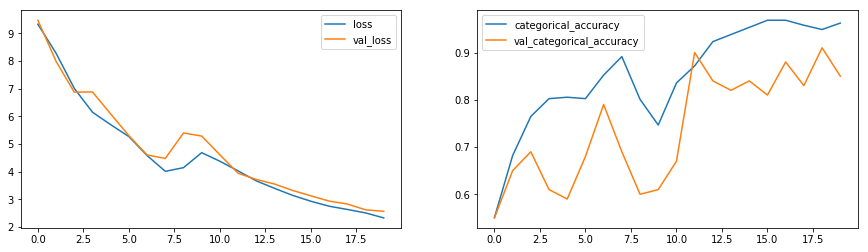

In [21]:
# Cleanup keras sessions
cleanup_keras_session()

# Build model
model_conv3d_5cl_filter_l2_regularizer = conv3d_5cl_filter_l2_regularizer(input_shape, nb_classes)

# Train model
history_conv3d_5cl_filter_l2_regularizer = train_model(model_conv3d_5cl_filter_l2_regularizer, batch_size, num_epochs, 
                                                         train_generator, val_generator,
                                                      model_full_name='conv3d_5cl_filter_l2_regularizer')

# Plot model - train and validation history - loss and accuracy curves
plot_model_history(history_conv3d_5cl_filter_l2_regularizer)

### Model 25 - conv3d_6cl_filter

`Conv3D - 6 layers (Neurons - 16/32/64/128/256/256) + Filter (1,1,1)`

`Model saved - Size: 38.9 MB - (https://drive.google.com/file/d/1u6OTae6WLXRQRvLwDIhBSzE3MVlTarNa/view?usp=sharing)`

- 15th Epoch

- Loss - 0.1391
- Categorical Accuracy - 0.9612

- Val Loss - 0.4143
- Val Categorical Accuracy - 0.8600


#### `Comments:`
##### `Quite a good model. Low loss and very high accuracy. Validation accuracy is also quite good, within 10% variation.`

Keras Session Cleaned up...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 16)  64        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 32)    544       
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 


Epoch 00015: val_loss improved from 0.45284 to 0.41427, saving model to model_conv3d_6cl_filter/conv3d_6cl_filter_best_model.h5
Epoch 16/20
67/67 [==============================] - 85s 1s/step - loss: 0.1631 - categorical_accuracy: 0.9443 - val_loss: 0.4974 - val_categorical_accuracy: 0.8200

Epoch 00016: val_loss did not improve from 0.41427
Epoch 17/20
67/67 [==============================] - 84s 1s/step - loss: 0.2056 - categorical_accuracy: 0.9354 - val_loss: 0.4598 - val_categorical_accuracy: 0.8700

Epoch 00017: val_loss did not improve from 0.41427

Epoch 00017: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.
Epoch 18/20
67/67 [==============================] - 86s 1s/step - loss: 0.1567 - categorical_accuracy: 0.9433 - val_loss: 0.5810 - val_categorical_accuracy: 0.8200

Epoch 00018: val_loss did not improve from 0.41427
Epoch 19/20
67/67 [==============================] - 82s 1s/step - loss: 0.1457 - categorical_accuracy: 0.9627 - val_loss: 0.4191 - val_cat

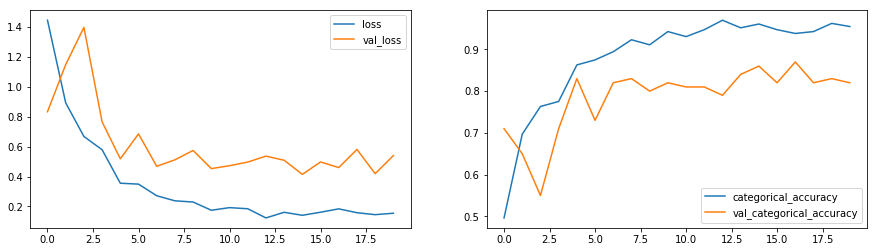

In [24]:
# Cleanup keras sessions
cleanup_keras_session()

# Build model
model_conv3d_6cl_filter = conv3d_6cl_filter(input_shape, nb_classes)

# Train model
history_conv3d_6cl_filter = train_model(model_conv3d_6cl_filter, batch_size, num_epochs, 
                                                         train_generator, val_generator,
                                                      model_full_name='conv3d_6cl_filter')

# Plot model - train and validation history - loss and accuracy curves
plot_model_history(history_conv3d_6cl_filter)

### Model 26 - conv3d_6cl_filter_l2_regularizer

`Conv3D - 6 layers (Neurons - 16/32/64/128/256/256) + Filter (1,1,1) + L2 Regularizer`

`Model saved - Size: 38.9 MB - (https://drive.google.com/file/d/1vs_iJvl1Qbk2Vq0LrZeiAhksV5fnYroz/view?usp=sharing)`

- 20th Epoch

- Loss - 2.7496
- Categorical Accuracy - 0.9627

- Val Loss - 2.9634
- Val Categorical Accuracy - 0.8500


#### `Comments:`
##### `Not a good model in comparison to model 23 and 25. Loss is high.`

Keras Session Cleaned up...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 16)  64        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 32)    544       
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 

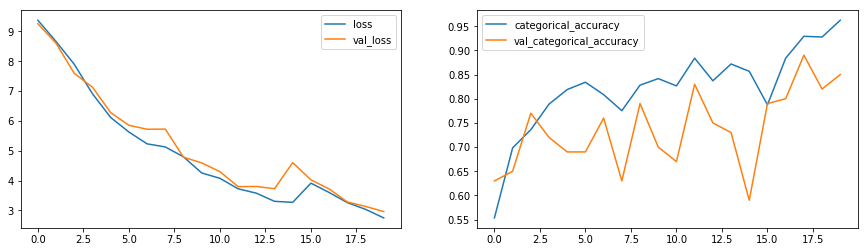

In [25]:
# Cleanup keras sessions
cleanup_keras_session()

# Build model
model_conv3d_6cl_filter_l2_regularizer = conv3d_6cl_filter_l2_regularizer(input_shape, nb_classes)

# Train model
history_conv3d_6cl_filter_l2_regularizer = train_model(model_conv3d_6cl_filter_l2_regularizer, batch_size, num_epochs, 
                                                         train_generator, val_generator,
                                                      model_full_name='conv3d_6cl_filter_l2_regularizer')

# Plot model - train and validation history - loss and accuracy curves
plot_model_history(history_conv3d_6cl_filter_l2_regularizer)

### Model 27 - conv3d_7cl_filter

`Conv3D - 7 layers (Neurons - 16/32/64/128/256/256/256) + Filter (1,1,1)`

`Model saved - Size: 39.7 MB - (https://drive.google.com/file/d/1TJY6NX--Scb6d64vxNrQtQbhp3zmlpYq/view?usp=sharing)`

- 7th Epoch

- Loss - 0.2789
- Categorical Accuracy - 0.9055

- Val Loss - 0.5064
- Val Categorical Accuracy - 0.8200


#### `Comments:`
##### `Model is good. Loss is low. Accuracy is good and validation accuracy is also good, within 10% variation.`
##### `Though best model was at 7th epoch, loss and accuracies kept oscillating in rest of epochs but did not go worse.`

Keras Session Cleaned up...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 16)  64        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 32)    544       
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 

67/67 [==============================] - 86s 1s/step - loss: 0.1958 - categorical_accuracy: 0.9369 - val_loss: 0.8999 - val_categorical_accuracy: 0.7000

Epoch 00014: val_loss did not improve from 0.50639
Epoch 15/20
67/67 [==============================] - 84s 1s/step - loss: 0.2471 - categorical_accuracy: 0.9155 - val_loss: 0.6899 - val_categorical_accuracy: 0.7600

Epoch 00015: val_loss did not improve from 0.50639

Epoch 00015: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
Epoch 16/20
67/67 [==============================] - 86s 1s/step - loss: 0.1866 - categorical_accuracy: 0.9309 - val_loss: 0.7553 - val_categorical_accuracy: 0.7700

Epoch 00016: val_loss did not improve from 0.50639
Epoch 17/20
67/67 [==============================] - 82s 1s/step - loss: 0.1793 - categorical_accuracy: 0.9418 - val_loss: 0.7055 - val_categorical_accuracy: 0.7400

Epoch 00017: val_loss did not improve from 0.50639

Epoch 00017: ReduceLROnPlateau reducing learning rate to 3.20

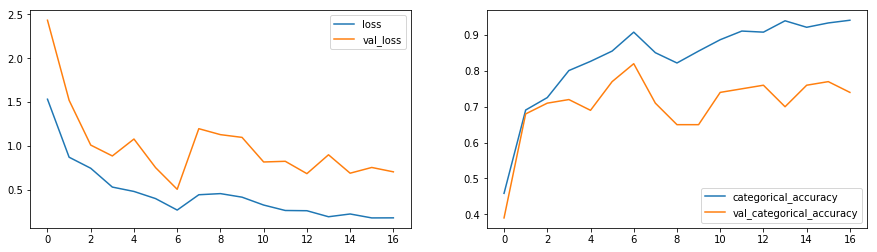

In [20]:
# Cleanup keras sessions
cleanup_keras_session()

# Build model
model_conv3d_7cl_filter = conv3d_7cl_filter(input_shape, nb_classes)

# Train model
history_conv3d_7cl_filter = train_model(model_conv3d_7cl_filter, batch_size, num_epochs, 
                                                         train_generator, val_generator,
                                                      model_full_name='conv3d_7cl_filter')

# Plot model - train and validation history - loss and accuracy curves
plot_model_history(history_conv3d_7cl_filter)

### Model 28 - mobilenet_transfer_learning_gru - 10 epochs

`MobileNet Transfer Learning + GRU`

`Model saved - Size: 42.1 MB - (https://drive.google.com/file/d/1XuaWXSswKAvO-7U2h5IYTZxxYEUeRBf7/view?usp=sharing)`

- 10th Epoch

- Loss - 0.0295
- Categorical Accuracy - 0.9861

- Val Loss - 0.1590
- Val Categorical Accuracy - 0.9600


#### `Comments:`
##### `A very good model. Low loss and high accuracy. Validation accuracy is almost same.`

Keras Session Cleaned up...
17227776/17225924 [==============================] - 2s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 1024)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               442752    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 3,676,357
Trainable params: 3,652,4

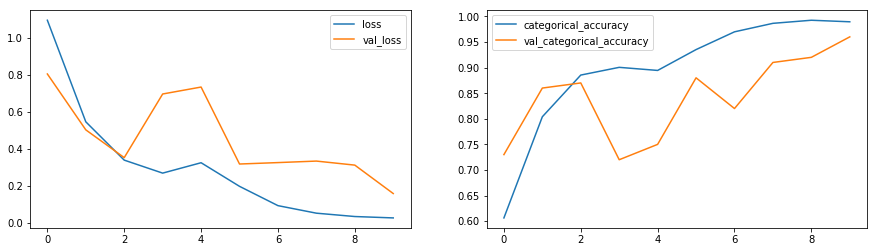

In [26]:
# Cleanup keras sessions
cleanup_keras_session()

num_epochs = 10

# Build model
model_mobilenet_transfer_learning_gru = mobilenet_transfer_learning_gru(input_shape, nb_classes)

# Train model
history_mobilenet_transfer_learning_gru = train_model(model_mobilenet_transfer_learning_gru, batch_size, num_epochs, 
                                                         train_generator, val_generator,
                                                      model_full_name='mobilenet_transfer_learning_gru')

# Plot model - train and validation history - loss and accuracy curves
plot_model_history(history_mobilenet_transfer_learning_gru)

### Model 29 - mobilenet_v2_transfer_learning_gru - 10 epochs

`MobileNet V2 Transfer Learning + GRU`

`Model saved - Size: 49.1 MB - (https://drive.google.com/file/d/1zrAvP8Ee-Qy-HKDwA6-3xIGgRgVz9LTE/view?usp=sharing)`

- 10th Epoch

- Loss - 0.1222
- Categorical Accuracy - 0.9627

- Val Loss - 0.5233
- Val Categorical Accuracy - 0.7800


#### `Comments:`
##### `Not a good model in comparison to model 28. Validation accuracy is low.`

Keras Session Cleaned up...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 4, 4, 1280)    2257984   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 4, 4, 1280)    5120      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 2, 2, 1280)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 5120)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               2015616   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 4,279,365
Trainable params: 4,242,693
Non-trainable params: 36,672
_________________________________

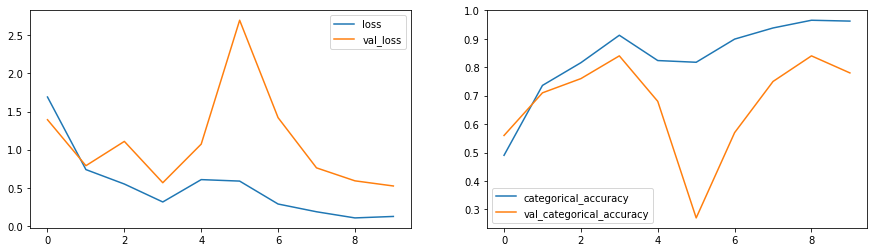

In [12]:
# Cleanup keras sessions
cleanup_keras_session()

num_epochs = 10

# Build model
model_mobilenet_v2_transfer_learning_gru = mobilenet_v2_transfer_learning_gru(input_shape, nb_classes)

# Train model
history_mobilenet_v2_transfer_learning_gru = train_model(model_mobilenet_v2_transfer_learning_gru, batch_size, num_epochs, 
                                                         train_generator, val_generator,
                                                      model_full_name='mobilenet_v2_transfer_learning_gru')

# Plot model - train and validation history - loss and accuracy curves
plot_model_history(history_mobilenet_v2_transfer_learning_gru)

### Model 30 - efficientnet_b0_transfer_learning_gru - 10 epochs

`EfficientNet B0 Transfer Learning + GRU`

`Model saved - Size: 52.8 MB - (https://drive.google.com/file/d/1yr2SGfnf6ITgVcx4IE6x9CBOWdXAl4-S/view?usp=sharing)`

- 7th Epoch

- Loss - 0.0269
- Categorical Accuracy - 0.9936

- Val Loss - 0.0594
- Val Categorical Accuracy - 0.9800


#### `Comments:`
##### `Best model so far. Lowest loss and highest accuracy. Validation accuracy is almost same.`

Keras Session Cleaned up...
Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, None, 1280)        4049564   
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 1280)        0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               541056    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 4,591,265
Trainable params: 4,549,249
Non-trainable params: 42,016
_________________________________________________________________
None
Source path =  Source path =  Project_data/train ; batch size = 10
Epoch 1/10
Project_data/val ; batch size = 10
67/67 [=

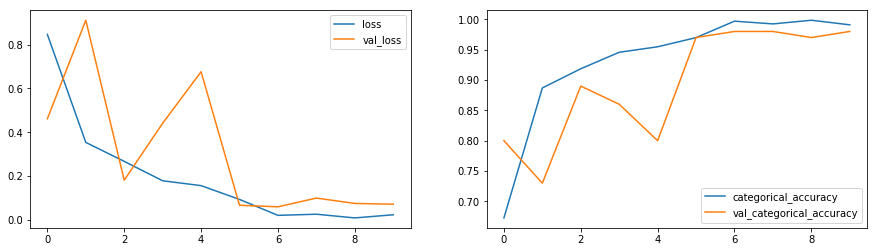

In [12]:
# Cleanup keras sessions
cleanup_keras_session()

num_epochs = 10

l_input_shape = (120, 120, 3)

# Build model
model_efficientnet_b0_transfer_learning_gru = efficientnet_b0_transfer_learning_gru(l_input_shape, nb_classes)

# Train model
history_efficientnet_b0_transfer_learning_gru = train_model(model_efficientnet_b0_transfer_learning_gru, batch_size, num_epochs, 
                                                         train_generator, val_generator,
                                                      model_full_name='efficientnet_b0_transfer_learning_gru')

# Plot model - train and validation history - loss and accuracy curves
plot_model_history(history_efficientnet_b0_transfer_learning_gru)

# `Conclusion:`
    
In this project, we prepared 3 types of models involving Conv2D + RNN (LSTM / GRU), Conv3D and Transfer Learning.

- In case of Conv2D + LSTM, best model is model 5 (size 30.6 MB)

- In case of Conv2D + GRU, best model is model 12 (size 23.1 MB)

- In case of Conv3D, best model is model 23 (size 38.1 MB)

- In case of Transfer learning, best models are model 28 (size 42.1 MB) as well as model 30 (size 52.8 MB).


### `Best Models : Transfer Learning Architecture`

##### If 52.8 MB size is manageable in memory of webcam then final chosen model is model 30.  Its training time is bit higher (but manageable) than model 28 but once trained, it has lowest loss and highest accuracy.

##### If model 30 is not acceptable due to memory size of webcam then model 28 is next best. Its training time is low. It has second lowest loss and second highest accuracy.

#### Both model 28 and 30 from transfer learning architecture, are very good.

### `Best Model : Conv3D Architecture`

##### If transfer learning models are not acceptable and memory is still an issue then model 23 is next best. It has both accuracies almost equal (~0.91). Though best model was at 8th epoch, loss and accuracies kept oscillating in rest of epochs but did not go worse. We have explained earlier as well, not all models needed to be trained for 20 epochs. We have just kept it 20 to keep it consistent and show variations in other models.

### `Best Model : Conv2D + GRU Architecture`

##### If size of the model, is still an issue due to memory size of webcam then model 12 is next best. It has low loss and high accuracy. Validation accuracy is relatively ok (above 80%).

### `Best Model : Conv2D + LSTM Architecture`

#### If someone wants to use LSTM then model 5 is best among LSTM models. It has low loss and high accuracy. Validation accuracy is also comparable.


## `Our Suggestion:`
## `Model 30 (EfficientNet_B0 + GRU) followed by Model 28 (MobileNet + GRU)`